<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

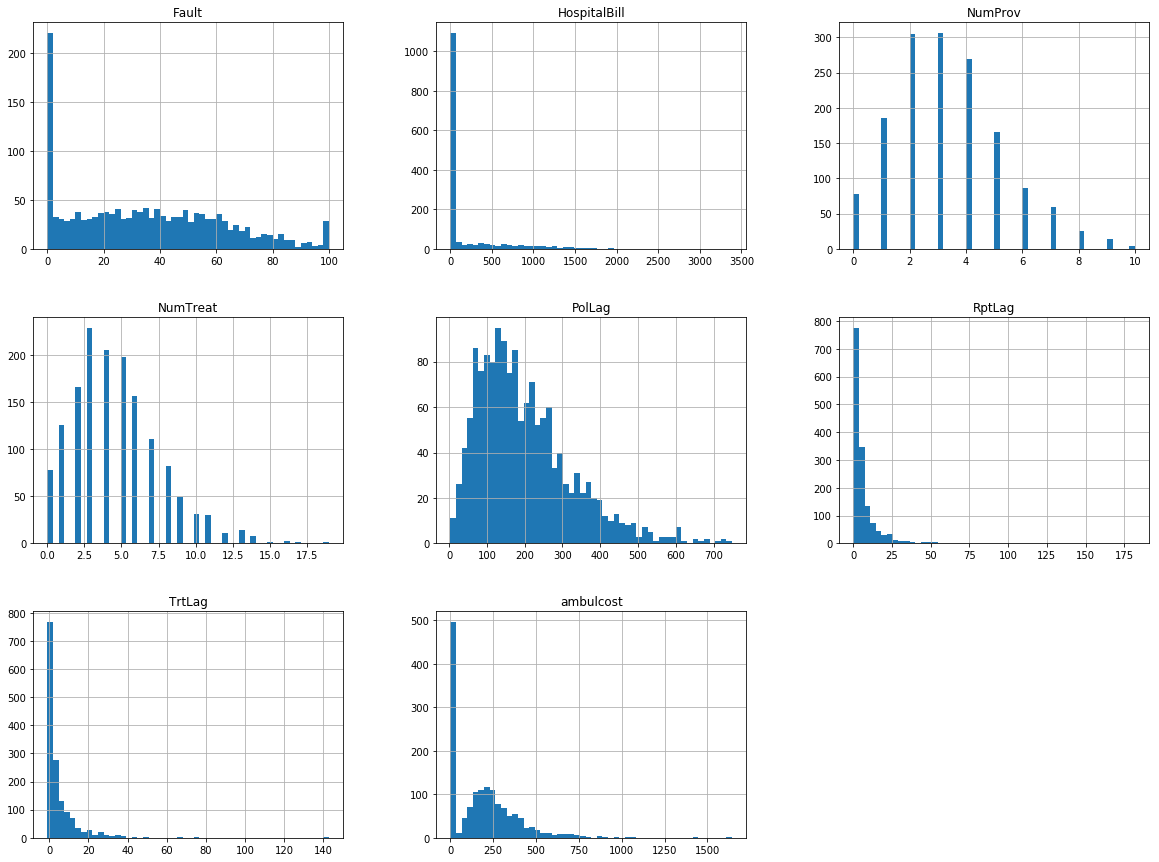

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.naive_bayes import BernoulliNB as BNB


from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import precision_score,recall_score,f1_score,roc_curve,accuracy_score
from sklearn.metrics import precision_recall_curve as prc
#from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import roc_auc_score as auc_score
from sklearn.model_selection import cross_val_predict as cvp
#from sklearn.model_selection import cross_val_score as cvs



from sklearn.ensemble import AdaBoostClassifier as Ada
from sklearn.ensemble import GradientBoostingClassifier as GBDT
import xgboost 
import lightgbm
from xgboost import XGBClassifier as XGBC
from lightgbm import LGBMClassifier as LGBC

#lightgbm默认安装在本地python环境中，而anaconda的python路径与本地路径不同，不能使用本地环境中的包，
#因此无法在anaconda jupyter notebook导入lightgbm包。
#conda install -c conda-forge lightgbm
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import ExtraTreesClassifier as ExtraTree
from sklearn.ensemble import BaggingClassifier as Bagging

from mlxtend.classifier import StackingClassifier as Stacking
from sklearn.ensemble import VotingClassifier as Voting


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
import matplotlib.pyplot as plt
import time
import graphviz
from sklearn import tree as Tree
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from mlxtend.classifier import StackingCVClassifier as StackingCV

import warnings
warnings.filterwarnings('ignore')

data=pd.read_csv('SimPIP.csv')
data['Suspicion']-=1
X=data.iloc[:,2:len(data)]
y=data['Suspicion']


#X.describe()

X_cat=[]
X_num=[]
for i in X:
    if (X[i]>2).any():
        X_num.append(i)
    else:
        X_cat.append(i)
X_cat=X[X_cat]
X_num=X[X_num]

X_num.hist(bins=50,figsize=(20,15))

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import robust_scale
from sklearn.pipeline import FeatureUnion
from sklearn_features.transformers import DataFrameSelector
onehot_encoder=OneHotEncoder(sparse=False)

num_attribs = list(X_num)
cat_attribs =list(X_cat)





num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('minmax_scaler', MinMaxScaler(feature_range=(0,1))),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('onehot_encoder',onehot_encoder),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

X_prepared = full_pipeline.fit_transform(X)

#X_train,X_test,y_train,y_test=tts(X_prepared,y,test_size=0.2,random_state=42)

X_train_original,X_test_original,y_train,y_test=tts(X,y,test_size=0.2,random_state=42)
X_train=full_pipeline.fit_transform(X_train_original)
X_test=full_pipeline.fit_transform(X_test_original)

logit=LR()
svm=SVC()
tree=DT()
knn=KNN()
gnb=GNB()
bnb=BNB()
mnb=MNB()

GBM=GBDT()
xgb=XGBC(n_jobs=-1)
lgbm=LGBC(n_jobs=-1)

rf=RF()
extree=ExtraTree()

In [29]:
X_pandas=pd.DataFrame(X_prepared)
X_train_pandas=pd.DataFrame(X_train)
X_test_pandas=pd.DataFrame(X_test)


In [2]:
def Individual(learner,param,methods='predict_proba',train_data=X_train,test_data=X_test,data=X_prepared,scorings='accuracy'):
    time_start=time.clock()

    
    grid_search=GridSearchCV(learner,param,cv=3,scoring=scorings)
    grid_search.fit(train_data,y_train)
    predict=grid_search.predict(test_data)
    time_end=time.clock()
    print(time_end-time_start)
    runtime=time_end-time_start
    
    accuracy=accuracy_score(predict,y_test)
    precision=precision_score(predict,y_test)
    recall=recall_score(predict,y_test)
    f1=f1_score(predict,y_test)
   

    y_scores=cvp(learner,X_prepared,y,cv=3,method=methods)#返回预测值
    if y_scores.ndim>=2:
        y_scores=y_scores[:,1]

    precisions,recalls,thresholds_prc=prc(y,y_scores)
    fpr,tpr,thresholds_roc=roc_curve(y,y_scores)
    auc=auc_score(y,y_scores)
    
    plt.figure(figsize=[12,6])
    
    plt.subplot(121)
    plt.plot(recalls,precisions,'b--',label='precision-recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='upper right')
    
    
    
    plt.subplot(122)
    plt.plot(fpr,tpr,linewidth=2,label='ROC')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend(loc='upper right')
    
    

    return [accuracy,precision,recall,f1,auc,precisions,recalls,fpr,tpr,grid_search.best_params_,grid_search.best_estimator_,runtime]


def Generator(learner,methods='predict_proba',train_data=X_train,test_data=X_test,data=X_prepared):
    time_start=time.clock()
    
    learner.fit(train_data,y_train)
    predict=learner.predict(test_data)
    time_end=time.clock()
    print(time_end-time_start)
    runtime=time_end-time_start
    
    accuracy=accuracy_score(predict,y_test)    
    precision=precision_score(predict,y_test)
    recall=recall_score(predict,y_test)
    f1=f1_score(predict,y_test)
   

    y_scores=cvp(learner,data,y,cv=3,method=methods)#返回预测值
    if y_scores.ndim>=2:
        y_scores=y_scores[:,1]
    
    precisions,recalls,thresholds_prc=prc(y,y_scores)
    fpr,tpr,thresholds_roc=roc_curve(y,y_scores)
    auc=auc_score(y,y_scores)
    
    plt.figure(figsize=[12,6])
    
    plt.subplot(121)
    plt.plot(recalls,precisions,'b--',label='precision-recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='upper right')
    
    
    
    plt.subplot(122)
    plt.plot(fpr,tpr,linewidth=2,label='ROC')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend(loc='upper right')
    
    

    return [accuracy,precision,recall,f1,auc,precisions,recalls,fpr,tpr,learner,runtime]


def Tunning(learner,param,methods='predict_proba',train_data=X_train,test_data=X_test,data=X_prepared,scorings='accuracy'):
    time_start=time.clock()
    
    grid_search=GridSearchCV(learner,param,cv=3,scoring=scorings)
    grid_search.fit(train_data,y_train)
    predict=grid_search.predict(test_data)
    
    time_end=time.clock()
    print(time_end-time_start)
    runtime=time_end-time_start
    
    accuracy=accuracy_score(predict,y_test)
    precision=precision_score(predict,y_test)
    recall=recall_score(predict,y_test)
    f1=f1_score(predict,y_test)
   

    y_scores=cvp(learner,X_prepared,y,cv=3,method=methods)#返回预测值
    if y_scores.ndim>=2:
        y_scores=y_scores[:,1]
     
    precisions,recalls,thresholds_prc=prc(y,y_scores)
    fpr,tpr,thresholds_roc=roc_curve(y,y_scores)
    auc=auc_score(y,y_scores)
    

    return [accuracy,precision,recall,f1,auc,grid_serach.best_prams_,grid_serach.best_estimator_,runtime]



def Base(learner,methods='predict_proba',train_data=X_train,test_data=X_test,data=X_prepared):
    time_start=time.clock()
    
    learner.fit(train_data,y_train)
    predict=learner.predict(test_data)
    
    time_end=time.clock()
    #print(time_end-time_start) 
    runtime=time_end-time_start
    
    accuracy=accuracy_score(predict,y_test)    
    precision=precision_score(predict,y_test)
    recall=recall_score(predict,y_test)
    f1=f1_score(predict,y_test)
   

    y_scores=cvp(learner,data,y,cv=3,method=methods)#返回预测值
    if y_scores.ndim>=2:
        y_scores=y_scores[:,1]


    precisions,recalls,thresholds_prc=prc(y,y_scores)
    fpr,tpr,thresholds_roc=roc_curve(y,y_scores)
    auc=auc_score(y,y_scores)
 
    return [accuracy,precision,recall,f1,auc,learner,runtime]


def plot_tree(classifier,name):
    dot_data= Tree.export_graphviz(classifier, out_file=None,feature_names
                =X.columns,filled=True,special_characters=True) 
    graph_tree = graphviz.Source(dot_data) 
    graph.render(name)
#['accuracy','precision','recall','f1','auc','learner','runtime']

def plot_result(ranges,result):
    accuracy=[i[0] for i in result]
    precision=[i[1] for i in result]
    recall=[i[2] for i in result]
    f1=[i[3] for i in result]
    auc=[i[4] for i in result]
    runtime=[i[-1] for i in result]
    
    plt.figure(figsize=(12, 6))
    plt.title('Performance')

    plt.plot(ranges, accuracy,'b.-',label='Accuracy')
    plt.plot(ranges,precision,'go--',label='Precision')
    plt.plot(ranges,recall,'r-.',label='recall')
    plt.plot(ranges,f1,'c:',label='F1')
    plt.plot(ranges,auc,'m+:',label='AUC')
    #plt.plot(ranges,runtime,'k--',label='runtime')
    plt.legend(loc='upper right')
    plt.xlabel(' Iterations')
    
def plot_feature_importance(result):
    feature_importance=result[-2].feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())#相对最重要的指标
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    plt.figure(figsize=(12, 6))

    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance')
    plt.show()


2.73543562011041
3.4506754404329008
0.03703117960013991
特征重要度 [0.39712758 0.00385187 0.036116   0.         0.01785667 0.03750446
 0.01201093 0.01470239 0.01440009 0.01185474 0.01867312 0.10863161
 0.01135257 0.00642647 0.00394492 0.01018105 0.00468588 0.01566816
 0.01442039 0.         0.04342607 0.14913409 0.         0.06125648
 0.00677446]
***************************************************************


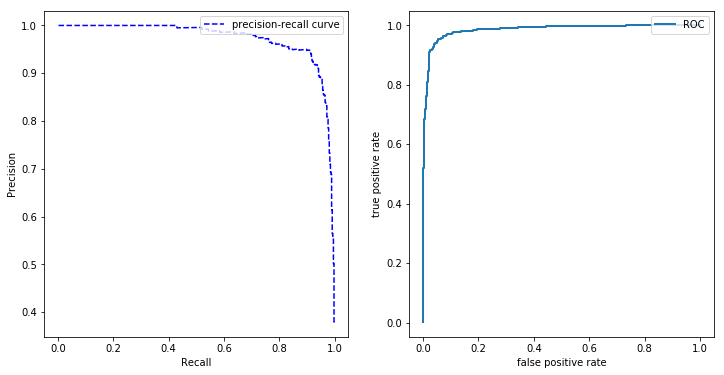

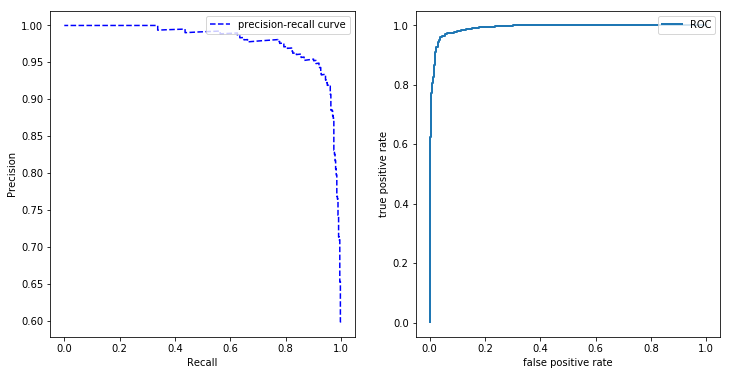

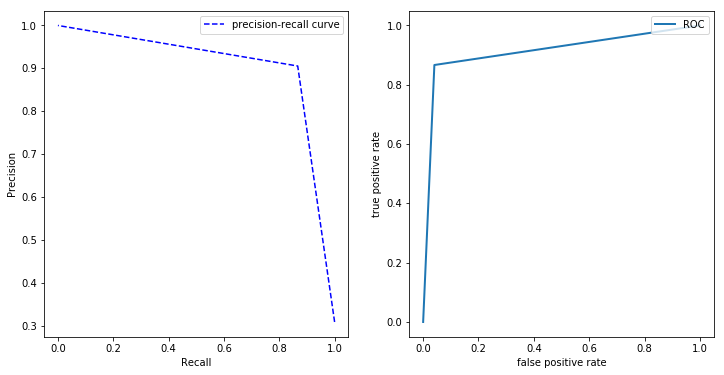

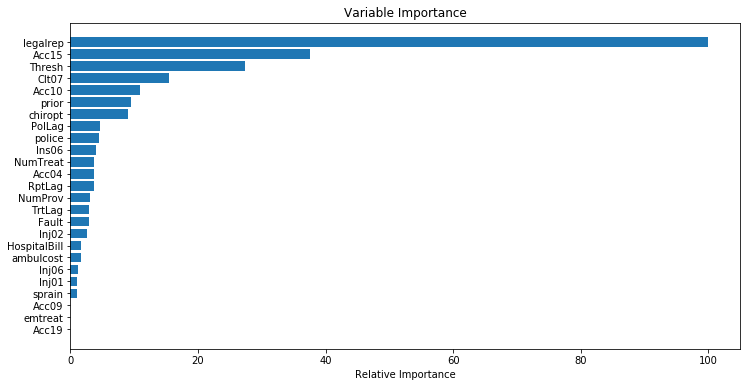

8.391447682806392
0.2159836410636835
0.08183848593936993
0.0028026255307729286
运行结果 
 [[0.97       0.96666667 0.93548387 0.95081967 0.98576905]
 [0.97333333 0.96666667 0.94565217 0.95604396 0.99034024]
 [0.96333333 0.91111111 0.96470588 0.93714286 0.91304348]
 [0.97       0.94444444 0.95505618 0.94972067 0.98306893]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94399252]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94628019]
 [0.89       0.93333333 0.75675676 0.8358209  0.93526882]]
**************************************************
最优参数 
 [{'C': 0.30000000000000004, 'penalty': 'l2', 'solver': 'newton-cg'}
 {'C': 0.9, 'kernel': 'rbf'}
 {'criterion': 'entropy', 'splitter': 'random'}
 {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
 {'alpha': 0.1, 'fit_prior': True} {'alpha': 0.1, 'fit_prior': True}]
**************************************************
运行时间 
 [2.73543562e+00 3.45067544e+00 3.70311796e-02 8.39144768e+00
 2.15983641e-01 8.18384859e-02 2.80262553e-03]
******************

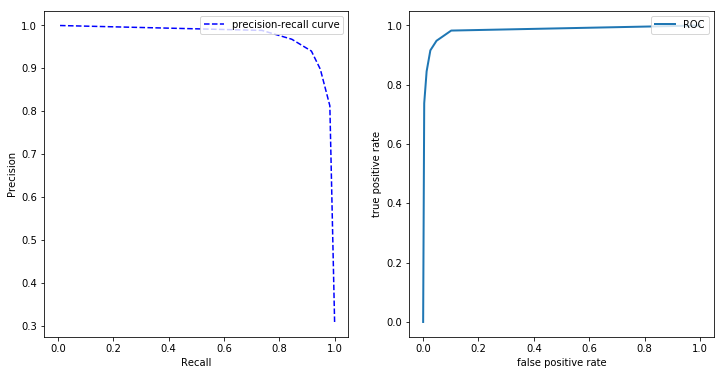

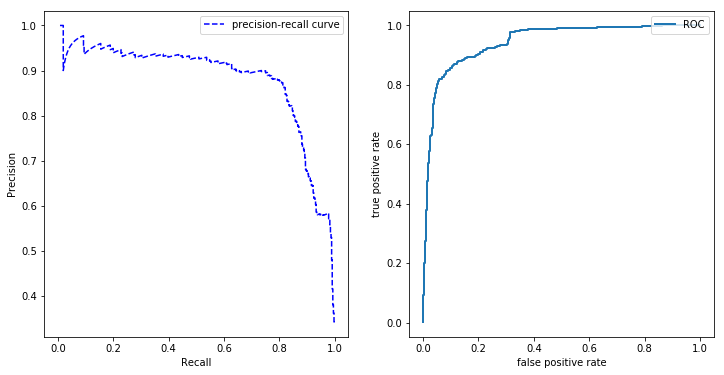

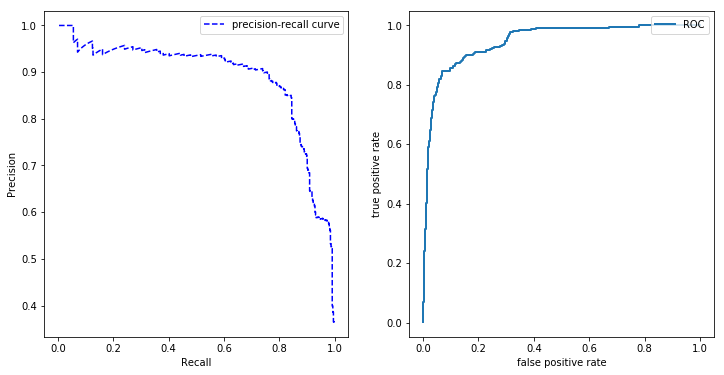

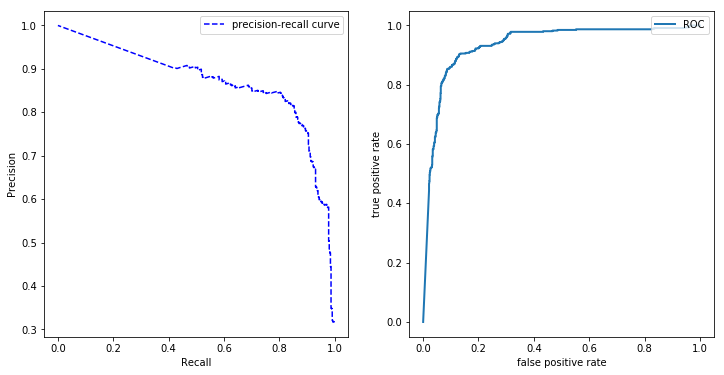

In [3]:
#############################################individual learner###################################################################
logit=LR()
svm=SVC()
tree=DT()
knn=KNN()
gnb=GNB()
bnb=BNB()
mnb=MNB()

logit_param=[{'C':np.arange(0.1,1.1,0.1),'penalty':['l1'],'solver':['liblinear','saga']},
             {'C':np.arange(0.1,1.1,0.1),'penalty':['l2'],'solver':['newton-cg','sag','lbfgs']}]
logit_result=Individual(logit,logit_param,methods='decision_function')


svm_param=[{'C':np.arange(0.1,1.1,0.1),'kernel':['linear', 'poly', 'rbf', 'sigmoid']}]
svm_result=Individual(svm,svm_param,methods='decision_function')

tree_param=[{'criterion':['gini','entropy'],'splitter':['best','random']}]
tree_result=Individual(tree,tree_param,train_data=X_train_original,test_data=X_test_original,data=X)
#树模型不需要进行归一化和one-hot编码
dot_data= Tree.export_graphviz(tree_result[-2], feature_names=X.columns,filled=True,special_characters=True) 
graph_tree = graphviz.Source(dot_data) 
#graph_tree.render('Decision Tree')
print('特征重要度',tree_result[10].feature_importances_)

print('***************************************************************')
plot_feature_importance(tree_result)
knn_param=[{'n_neighbors':np.arange(3,28,2),'weights':['uniform','distance'],'p':[1,2]}]
knn_result=Individual(knn,knn_param,methods='predict_proba')

bnb_param=[{'alpha':np.arange(0.1,1.1,0.1),'fit_prior':[False,True]}]
bnb_result=Individual(bnb,bnb_param,methods='predict_proba')

mnb_param=[{'alpha':np.arange(0.1,1.1,0.1),'fit_prior':[False,True]}]
mnb_result=Individual(mnb,mnb_param,methods='predict_proba')

gnb_result=Generator(gnb)

result_number=np.array([logit_result[:5],svm_result[:5],tree_result[:5],knn_result[:5],bnb_result[:5],mnb_result[:5],gnb_result[:5]])
result_graph=np.array([logit_result[5:9],svm_result[5:9],tree_result[5:9],knn_result[5:9],bnb_result[5:9],mnb_result[5:9],gnb_result[5:9]])
result_best_param=np.array([logit_result[9],svm_result[9],tree_result[9],knn_result[9],bnb_result[9],mnb_result[9]])
result_best_estimator=np.array([logit_result[10],svm_result[10],tree_result[10],knn_result[10],bnb_result[10],mnb_result[10],gnb_result[9]])
result_runtime=np.array([logit_result[-1],svm_result[-1],tree_result[-1],knn_result[-1],bnb_result[-1],mnb_result[-1],gnb_result[-1]])
np.savetxt('result_number.txt',result_number)
np.save('result_graph.npy',result_graph)
np.save('result_best_param.npy',result_best_param)
np.save('result_best_estimator.npy',result_best_estimator)
np.savetxt('runtime.txt',result_runtime)

base_learner=['Logistic Regression','SVM','Decision Tree','kNN','Bernoulli Naive Bayes','Multinomial Naive Bayes','Gaussian Naive Bayes']

print('运行结果','\n', result_number)
print('**************************************************')
print('最优参数','\n',result_best_param)
print('**************************************************')
print('运行时间','\n',result_runtime)
print('**************************************************')
print('***************************************************************')
plot_feature_importance(tree_result)
#######################################################################################################################


0.049058632444939576


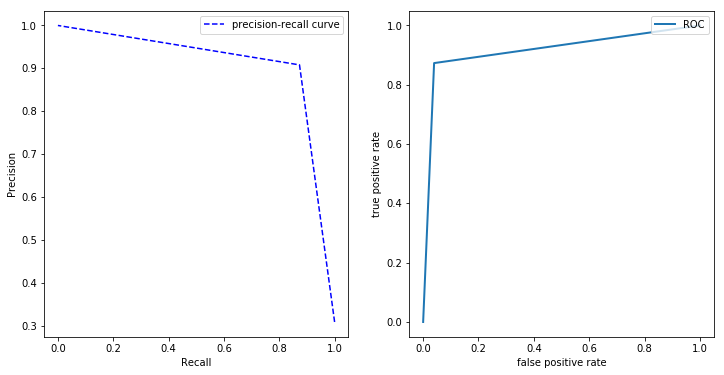

In [31]:
tree_param=[{'criterion':['gini','entropy'],'splitter':['best','random']}]
tree_result=Individual(tree,tree_param,train_data=X_train_original,test_data=X_test_original,data=X)

In [ ]:
#################################################Ada-optimal##############################################################################
result_number=np.loadtxt('result_number.txt')
result_graph=np.load('result_graph.npy')
result_best_param=np.load('result_best_param.npy')
result_best_estimator=np.load('result_best_estimator.npy')
result_runtime=np.loadtxt('runtime.txt')


Ada_param=[{'n_estimators':np.arange(5,105,5),'learning_rate':np.arange(0.01,1,0.03)}]
Ada_result=[0,0,0,0,0,0,0,0]

Ada_result[0]=Individual(Ada(result_best_estimator[0],algorithm='SAMME'),Ada_param,methods='decision_function')
Ada_result[1]=Individual(Ada(result_best_estimator[1],algorithm='SAMME'),Ada_param,methods='decision_function')
Ada_result[2]=Individual(Ada(result_best_estimator[2],algorithm='SAMME.R'),Ada_param,train_data=X_train_original,
                         test_data=X_test_original,data=X)

Ada_result[4]=Individual(Ada(result_best_estimator[4],algorithm='SAMME.R'),Ada_param,methods='predict_proba')
Ada_result[5]=Individual(Ada(result_best_estimator[5],algorithm='SAMME.R'),Ada_param,methods='predict_proba')
Ada_result[6]=Individual(Ada(gnb,algorithm='SAMME.R'),Ada_param,methods='predict_proba')

Ada_result_num=np.array([Ada_result[0][:5],Ada_result[1][:5],Ada_result[2][:5],Ada_result[4][:5],
                         Ada_result[5][:5],Ada_result[6][:5]])

Ada_result_best_param=np.array([Ada_result[0][9],Ada_result[1][9],Ada_result[2][9],Ada_result[4][9],
                         Ada_result[5][9]])

Ada_result_best_estimator=np.array([Ada_result[0][10],Ada_result[1][10],Ada_result[2][10],Ada_result[4][10],
                         Ada_result[5][10],Ada_result[6][9]])

Ada_result_runtime=np.array([Ada_result[0][-1],Ada_result[1][-1],Ada_result[2][-1],Ada_result[4][-1],
                         Ada_result[5][-1],Ada_result[6][-1]])

np.savetxt('Ada_result_num.txt',Ada_result_num)
np.save('Ada_result_best_param.npy',Ada_result_best_param)
np.save('Ada_result_best_estimator.npy',Ada_result_best_estimator)
np.savetxt('Ada_result_runtime.txt',Ada_result_runtime)

print('Adaboost 运行结果','\n',Ada_result_num)
print('****************************************************')
print('单学习器运行结果','\n',result_number)
print('****************************************************')
print('Adaboost各学习器的最优参数','\n',Ada_result_best_param)
print('*********************************************************')
print('Adaboost运行时间','\n',Ada_result_runtime)
print('****************************************************')
################################################################

####################################################################################################################################

In [ ]:
GBDT_param=[{'loss':['deviance','exponential'],'learning_rate':np.arange(0.01,1,0.03),'max_depth':np.arange(3,16),
             'n_estimators':np.arange(5,105,5)}]

GBDT_result=Individual(GBM,GBDT_param,train_data=X_train_original,test_data=X_test_original,data=X)
GBDT_result_pre_data=Individual(GBM,GBDT_param)
print('GBDT最优参数','\n',GBDT_result[-3])
print('*********************************************************')
print('Adamnb最优参数','\n',Ada_result_best_param[-1])
np.save('GBDT_result.npy',GBDT_result)
np.save('GBDT_result_pre_data.npy',GBDT_result_pre_data)

In [ ]:


Adamnb_n_estimators=list(np.arange(5,105,5))
Adamnb_learning_rate=list(np.arange(0.01,1.0,0.03))

GBDT_n_estimators=list(np.arange(5,105,5))
GBDT_learning_rate=list(np.arange(0.01,1.0,0.03))
GBDT_depth=list(np.arange(3,16))

for i,j in enumerate(np.arange(5,105,5)):
    GBM_ne=GBDT(n_estimators=j,loss='exponential',learning_rate=0.31,max_depth=5)
    Adamnb_n_estimators[i]=Base(Ada(result_best_estimator[5],algorithm='SAMME.R',n_estimators=j,learning_rate=0.70))
    GBDT_n_estimators[i]=Base(GBM_ne,train_data=X_train_original,test_data=X_test_original,data=X)
    

for i,j in enumerate(np.arange(0.01,1.0,0.03)):
    GBM_lr=GBDT(n_estimators=75,loss='exponential',learning_rate=j,max_depth=5)
    Adamnb_learning_rate[i]=Base(Ada(result_best_estimator[5],algorithm='SAMME.R',n_estimators=60,learning_rate=j))
    GBDT_learning_rate[i]=Base(GBM_lr,train_data=X_train_original,test_data=X_test_original,data=X)


for i,j in enumerate(np.arange(3,16)):
    GBM_md=GBDT(n_estimators=75,loss='exponential',learning_rate=0.31,max_depth=j)
    GBDT_depth[i]=Base(GBM_md,train_data=X_train_original,test_data=X_test_original,data=X)
    
print('GBDT运行结果','\n',GBDT_result[:5])
print('***************************************************************************')
print('GBDT特征重要度:','\n',GBDT_result[-2].feature_importances_)
print('***************************************************************************')
print('GBDT最优参数','\n',GBDT_result[-3])
print('*********************************************************')
print('GBDT运行时间','\n',GBDT_result[-1])
print('***************************************************************************')
np.save('GBDT_n_estimators.npy',GBDT_n_estimators)
np.save('GBDT_learning_rate.npy',GBDT_learning_rate)
np.save('GBDT_depth.npy',GBDT_depth)

np.save('GBDT_result.npy',GBDT_result)
np.save('GBDT_result_pre_data.npy',GBDT_result_pre_data)

np.save('adamnb_n_estimators.npy',Adamnb_n_estimators)
np.save('adamnb_learning_rate.npy',Adamnb_learning_rate)


plot_result(np.arange(5,105,5),GBDT_n_estimators)
plot_result(np.arange(0.01,1,0.03),GBDT_learning_rate)
plot_result(np.arange(3,16),GBDT_depth)

plot_result(np.arange(5,105,5),Adamnb_n_estimators)
plot_result(np.arange(0.01,1,0.03),Adamnb_learning_rate)

plot_feature_importance(GBDT_result)


Adaboost 运行结果 
 [[0.96333333 0.93333333 0.94382022 0.93854749 0.97735806]
 [0.7        0.         0.         0.         0.5       ]
 [0.95       0.91111111 0.92134831 0.91620112 0.92583762]
 [0.95666667 0.95555556 0.90526316 0.92972973 0.77922394]
 [0.96666667 0.96666667 0.92553191 0.94565217 0.9163472 ]
 [0.87666667 0.72222222 0.84415584 0.77844311 0.86564542]]
****************************************************
单学习器运行结果 
 [[0.97       0.96666667 0.93548387 0.95081967 0.98576905]
 [0.97333333 0.96666667 0.94565217 0.95604396 0.99034024]
 [0.96333333 0.91111111 0.96470588 0.93714286 0.91304348]
 [0.97       0.94444444 0.95505618 0.94972067 0.98306893]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94399252]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94628019]
 [0.89       0.93333333 0.75675676 0.8358209  0.93526882]]
****************************************************
Adaboost各学习器的最优参数 
 [{'learning_rate': 0.43, 'n_estimators': 95}
 {'learning_rate': 0.01, 'n_estimators': 5}
 {

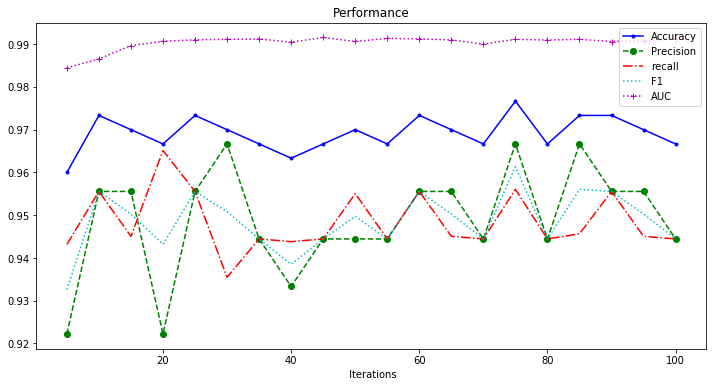

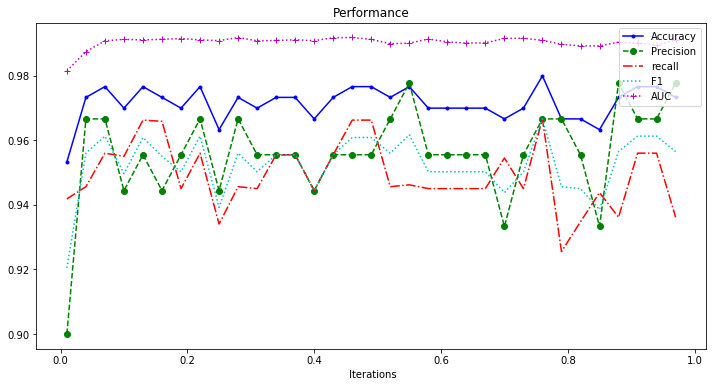

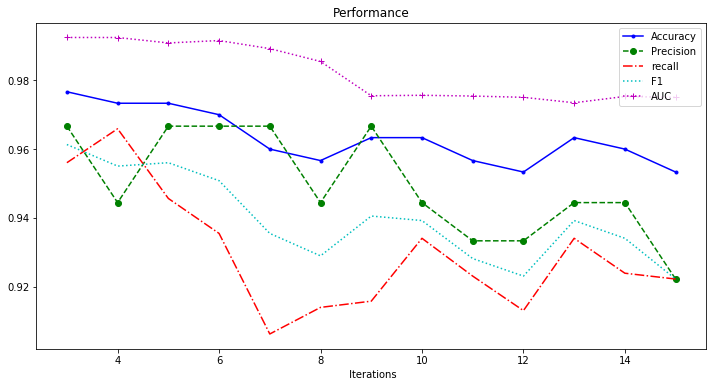

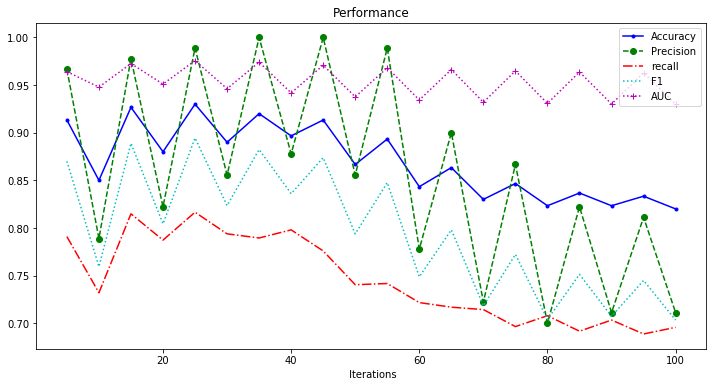

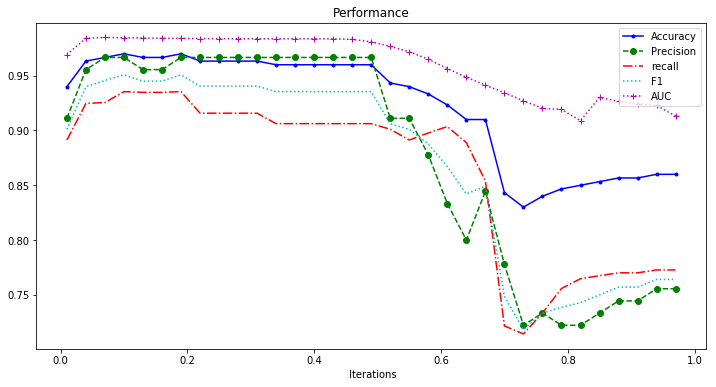

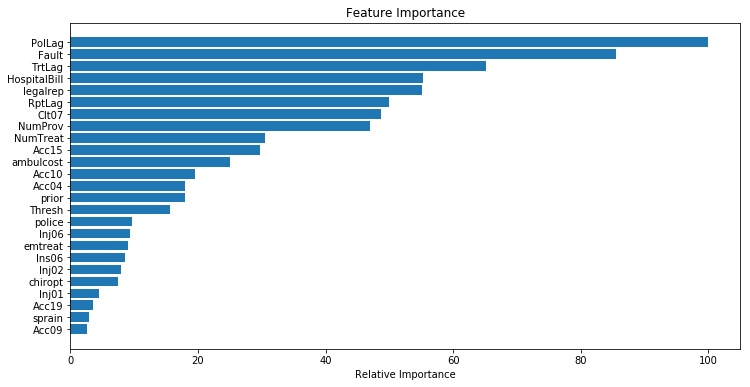

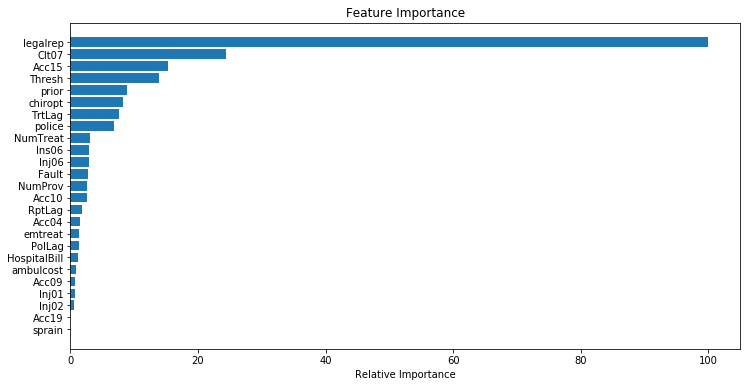

In [39]:
result_number=np.loadtxt('result_number.txt')
result_graph=np.load('result_graph.npy')
result_best_param=np.load('result_best_param.npy')
result_best_estimator=np.load('result_best_estimator.npy')
result_runtime=np.loadtxt('runtime.txt')

Ada_result_num=np.loadtxt('Ada_result_num.txt')
Ada_result_best_param=np.load('Ada_result_best_param.npy')
Ada_result_best_estimator=np.load('Ada_result_best_estimator.npy')
Ada_result_runtime=np.loadtxt('Ada_result_runtime.txt')

GBDT_result=np.load('GBDT_result.npy')
GBDT_result_pre_data=np.load('GBDT_result_pre_data.npy')

GBDT_n_estimators=np.load('GBDT_n_estimators.npy')
GBDT_learning_rate=np.load('GBDT_learning_rate.npy')
GBDT_depth=np.load('GBDT_depth.npy')

GBDT_result=np.load('GBDT_result.npy')
GBDT_result_pre_data=np.load('GBDT_result_pre_data.npy')

Adamnb_n_estimators=np.load('adamnb_n_estimators.npy')
Adamnb_learning_rate=np.load('adamnb_learning_rate.npy')

print('Adaboost 运行结果','\n',Ada_result_num)
print('****************************************************')
print('单学习器运行结果','\n',result_number)
print('****************************************************')
print('Adaboost各学习器的最优参数','\n',Ada_result_best_param)
print('*********************************************************')
print('Adaboost运行时间','\n',Ada_result_runtime)
print('****************************************************')

print('GBDT最优参数','\n',GBDT_result[-3])
print('*********************************************************')
print('Adamnb最优参数','\n',Ada_result_best_param[-1])

print('GBDT运行结果','\n',GBDT_result[:5])
print('***************************************************************************')
print('GBDT特征重要度:','\n',GBDT_result[-2].feature_importances_)
print('***************************************************************************')
print('GBDT最优参数','\n',GBDT_result[-3])
print('*********************************************************')
print('GBDT运行时间','\n',GBDT_result[-1])
print('***************************************************************************')

plot_result(np.arange(5,105,5),GBDT_n_estimators)
plot_result(np.arange(0.01,1,0.03),GBDT_learning_rate)
plot_result(np.arange(3,16),GBDT_depth)

plot_result(np.arange(5,105,5),Adamnb_n_estimators)
plot_result(np.arange(0.01,1,0.03),Adamnb_learning_rate)

plot_feature_importance(GBDT_result)
plot_feature_importance(tree_result)

3045.4116761936384
3133.6077316966075


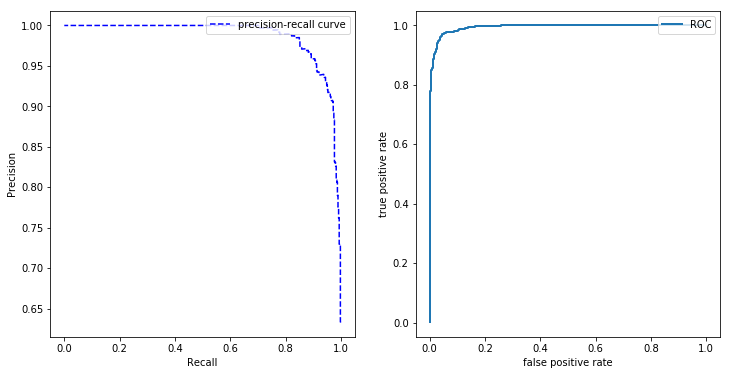

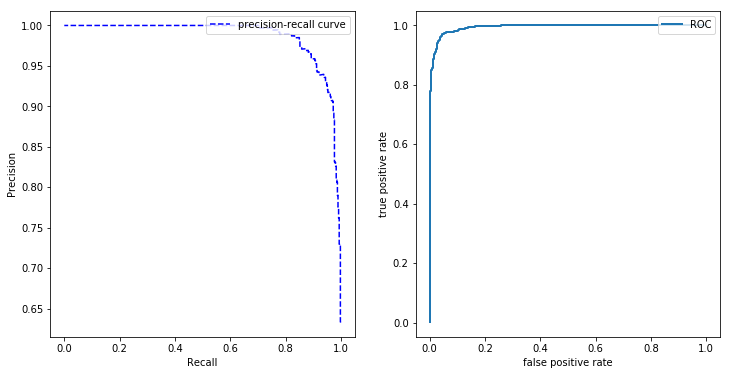

In [10]:
xgb=XGBC(n_jobs=-1)

train_xgb=xgboost.DMatrix(X_train_original,label=y_train)
test_xgb=xgboost.DMatrix(X_test_original,label=y_test)
X_xgb=xgboost.DMatrix(X,label=y)

train_xgb_pre=xgboost.DMatrix(X_train,label=y_train)
test_xgb_pre=xgboost.DMatrix(X_test,label=y_test)
X_xgb_pre=xgboost.DMatrix(X_prepared,label=y)

xgb_param=[{'max_depth':np.arange(3,16),'learning_rate':np.arange(0.01,1,0.03),'n_estimators':np.arange(5,105,5),'reg_lambda':[0],'reg_alpha':[1]},
           {'max_depth':np.arange(3,16),'learning_rate':np.arange(0.01,1,0.03),'n_estimators':np.arange(5,105,5),'reg_alpha':[0],'reg_lambda':[1]}
          ]

xgb_result=Individual(xgb,xgb_param,train_data=X_train_original,test_data=X_test_original,data=X)
xgb_result_pre_data=Individual(xgb,xgb_param)





In [12]:
print('xgboost结果','\n',xgb_result[:5])
print('*********************************************************')
print('xgboost特征重要度:','\n',xgb_result[-2].feature_importances_)
print('***************************************************************')
print('xgboost最优参数','\n',xgb_result[-3])
print('*********************************************************')
print('xgboost运行时间','\n',xgb_result[-1])

xgboost结果 
 [0.9733333333333334, 0.9444444444444444, 0.9659090909090909, 0.9550561797752809, 0.9933800841514726]
*********************************************************
xgboost特征重要度: 
 [0.05617978 0.         0.05617978 0.02247191 0.02247191 0.04494382
 0.03370786 0.01123596 0.07865169 0.10112359 0.08988764 0.03370786
 0.06741573 0.05617978 0.01123596 0.         0.03370786 0.01123596
 0.02247191 0.         0.05617978 0.06741573 0.         0.08988764
 0.03370786]
***************************************************************
xgboost最优参数 
 {'learning_rate': 0.82, 'max_depth': 3, 'n_estimators': 15, 'reg_alpha': 0, 'reg_lambda': 1}
*********************************************************
xgboost运行时间 
 3045.4116761936384


In [13]:
xgb_n_estimators=list(np.arange(5,105,5))
xgb_learning_rate=list(np.arange(0.01,1,0.03))
xgb_depth=list(np.arange(3,16))
xgb_L1=[]
xgb_L2=[]


for i,j in enumerate(np.arange(5,105,5)):
    xgb_ne=XGBC(n_jobs=-1,max_depth=3,learning_rate=0.82,n_estimators=j,reg_alpha=0,reg_lambda=1)
    
    xgb_n_estimators[i]=Base(xgb_ne,train_data=X_train_original,test_data=X_test_original,data=X)
    

for i,j in enumerate(np.arange(0.01,1,0.03)):
    xgb_lr=XGBC(n_jobs=-1,max_depth=3,learning_rate=j,n_estimators=15,reg_alpha=0,reg_lambda=1)
    
    xgb_learning_rate[i]=Base(xgb_lr,train_data=X_train_original,test_data=X_test_original,data=X)
    

for i,j in enumerate(np.arange(3,16)):
    xgb_md=XGBC(n_jobs=-1,max_depth=j,learning_rate=0.82,n_estimators=15,reg_alpha=0,reg_lambda=1)
    
    xgb_depth[i]=Base(xgb_md,train_data=X_train_original,test_data=X_test_original,data=X)
    
xgb_l1=XGBC(n_jobs=-1,max_depth=3,learning_rate=0.82,n_estimators=15,reg_alpha=1,reg_lambda=0)
xgb_L1=Base(xgb_l1,train_data=X_train_original,test_data=X_test_original,data=X)

xgb_l2=XGBC(n_jobs=-1,max_depth=3,learning_rate=0.82,n_estimators=15,reg_alpha=0,reg_lambda=1)
xgb_L2=Base(xgb_l2,train_data=X_train_original,test_data=X_test_original,data=X)
    
np.save('xgb_n_estimators.npy',xgb_n_estimators)
np.save('xgb_learning_rate.npy',xgb_learning_rate)
np.save('xgb_depth.npy',xgb_depth)
np.save('xgb_L1.npy',xgb_L1)
np.save('xgb_L2.npy',xgb_L2)

np.save('xgb_result.npy',xgb_result)
np.save('xgb_result_pre_data.npy',xgb_result_pre_data)

print('xgboost结果','\n',xgb_result[:5])
print('*********************************************************')
print('xgboost特征重要度:','\n',xgb_result[-2].feature_importances_)
print('***************************************************************')
print('xgboost最优参数','\n',xgb_result[-3])
print('*********************************************************')
print('xgboost运行时间','\n',xgb_result[-1])



xgboost结果 
 [0.9733333333333334, 0.9444444444444444, 0.9659090909090909, 0.9550561797752809, 0.9933800841514726]
*********************************************************
xgboost特征重要度: 
 [0.05617978 0.         0.05617978 0.02247191 0.02247191 0.04494382
 0.03370786 0.01123596 0.07865169 0.10112359 0.08988764 0.03370786
 0.06741573 0.05617978 0.01123596 0.         0.03370786 0.01123596
 0.02247191 0.         0.05617978 0.06741573 0.         0.08988764
 0.03370786]
***************************************************************
xgboost最优参数 
 {'learning_rate': 0.82, 'max_depth': 3, 'n_estimators': 15, 'reg_alpha': 0, 'reg_lambda': 1}
*********************************************************
xgboost运行时间 
 3045.4116761936384


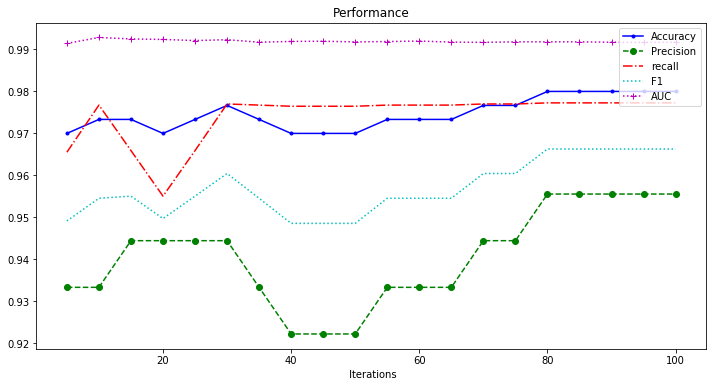

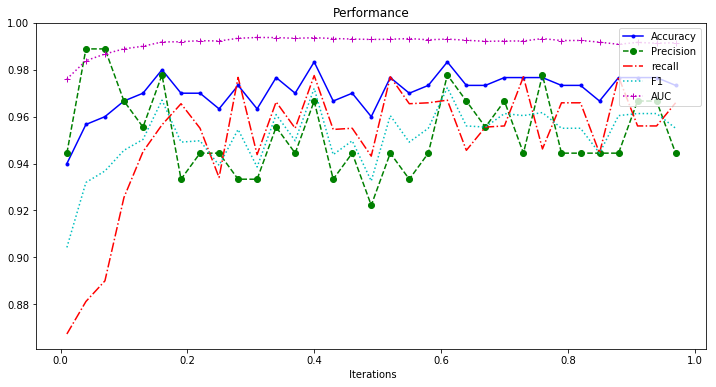

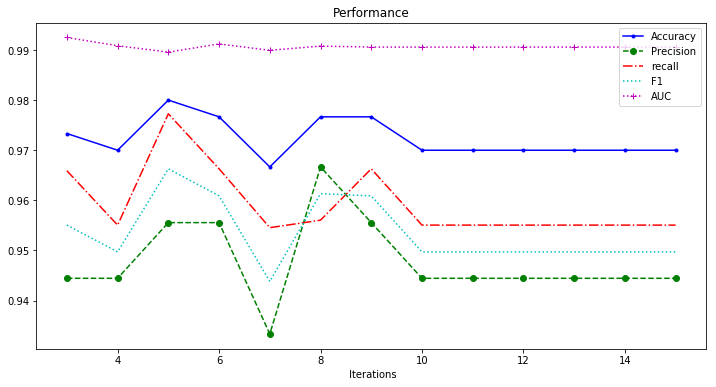

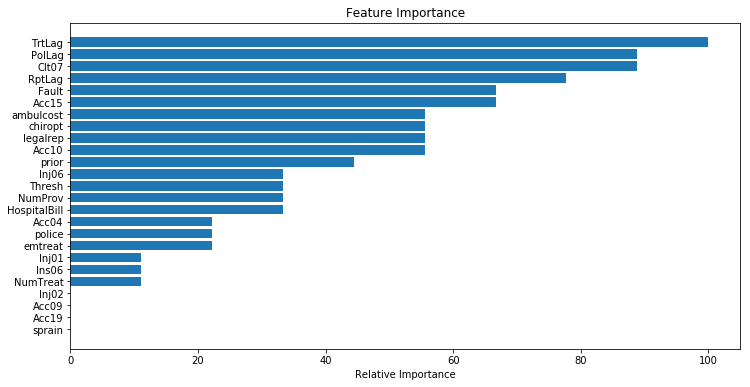

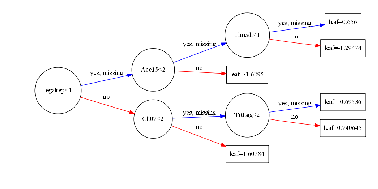

In [40]:
xgb_n_estimators=np.load('xgb_n_estimators.npy')
xgb_learning_rate=np.load('xgb_learning_rate.npy')
xgb_depth=np.load('xgb_depth.npy')
xgb_L1=np.load('xgb_L1.npy')
xgb_L2=np.load('xgb_L2.npy')

xgb_result=np.load('xgb_result.npy')
xgb_result_pre_data=np.load('xgb_result_pre_data.npy')


plot_result(np.arange(5,105,5),xgb_n_estimators)
plot_result(np.arange(0.01,1,0.03),xgb_learning_rate)
plot_result(np.arange(3,16),xgb_depth)
plot_feature_importance(xgb_result)

xgboost.plot_tree(xgb_result[-2], num_trees=0, rankdir= 'LR' )
#xgboost.plot_importance(xgb_result[-2], num_trees=0, rankdir= 'LR' )
#xgboost.to_graphviz(xgb_result[-2], num_trees=0, rankdir= 'LR' )
   
#xgboost.plot_tree(xgb_result[-2].get_booster(),num_tree=0,rankdir='UT')



##################################################lightGBM##################################################################

7549.025305066149
5172.917150536052
lightgbm结果 
 [0.98, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9920398940314789]
*********************************************************
lightgbm特征重要度: 
 [ 8  0  7  4  5  9  6  5 16 13 19  7 21  8  1  2  3  2  2  0 11 11  0 15
  5]
***************************************************************
lightgbm最优参数 
 {'boosting_type': 'goss', 'learning_rate': 0.58, 'n_estimators': 15, 'n_jobs': 1, 'num_leaves': 13, 'reg_alpha ': 1, 'reg_lambda': 0}
*********************************************************
lightgbm运行时间 
 7549.025305066149


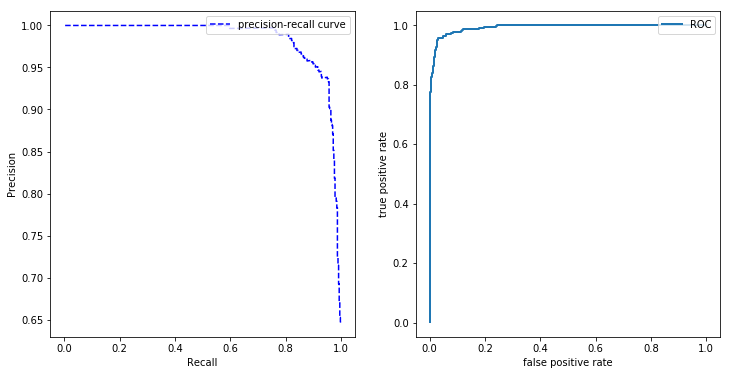

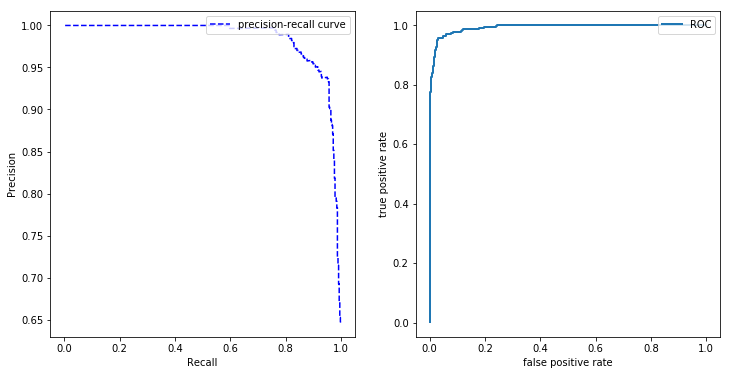

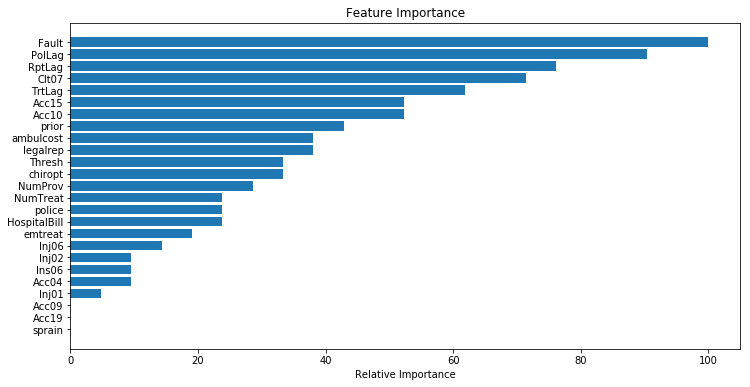

In [3]:
lgbm=LGBC()
train_lgbm=lightgbm.Dataset(X_train_original,label=y_train)
test_lgbm=lightgbm.Dataset(X_test_original,label=y_test)
X_lgbm=lightgbm.Dataset(X,label=y)

lgbm_param=[{'num_leaves':np.arange(10,150,3),'learning_rate':np.arange(0.01,1,0.03),'n_estimators':np.arange(5,105,5),'n_jobs':[1],
            'reg_alpha':[0],'reg_lambda':[1],'boosting_type':['goss']},
           {'num_leaves':np.arange(10,150,3),'learning_rate':np.arange(0.01,1,0.03),'n_estimators':np.arange(5,105,5),'n_jobs':[1],
            'reg_lambda':[0],'reg_alpha ':[1],'boosting_type':['goss']}
          ]

lgbm_result=Individual(lgbm,lgbm_param,train_data=X_train_original,test_data=X_test_original,data=X)
lgbm_result_pre_data=Individual(lgbm,lgbm_param)

print('lightgbm结果','\n',lgbm_result[:5])
print('*********************************************************')
print('lightgbm特征重要度:','\n',lgbm_result[-2].feature_importances_)
print('***************************************************************')

print('lightgbm最优参数','\n',lgbm_result[-3])
print('*********************************************************')
print('lightgbm运行时间','\n',lgbm_result[-1])
plot_feature_importance(lgbm_result) 

In [1]:
import numpy as np
lgbm_result_pre_data=np.load('lgbm_result_pre_data.npy')
print(lgbm_result_pre_data)

[0.97 0.9777777777777777 0.9263157894736842 0.9513513513513514
 0.9920398940314789
 array([0.64763231, 0.64714086, 0.64804469, 0.64895105, 0.64985994,
       0.65077139, 0.65168539, 0.65260197, 0.65211268, 0.65303244,
       0.6539548 , 0.65487977, 0.65580737, 0.65673759, 0.65767045,
       0.65860597, 0.65954416, 0.66048502, 0.66142857, 0.66237482,
       0.66332378, 0.66427547, 0.66522989, 0.66618705, 0.66714697,
       0.66810967, 0.66907514, 0.67004342, 0.66956522, 0.67053701,
       0.67151163, 0.67248908, 0.67346939, 0.67445255, 0.6754386 ,
       0.67642753, 0.67741935, 0.6784141 , 0.67941176, 0.68041237,
       0.68141593, 0.68242245, 0.68343195, 0.68444444, 0.68545994,
       0.68647845, 0.6875    , 0.68852459, 0.68955224, 0.69058296,
       0.69161677, 0.69265367, 0.69219219, 0.69323308, 0.69427711,
       0.69532428, 0.69637462, 0.69742814, 0.69848485, 0.69954476,
       0.7006079 , 0.70167428, 0.7027439 , 0.70381679, 0.70489297,
       0.70597243, 0.70705521, 0.70814132, 0.

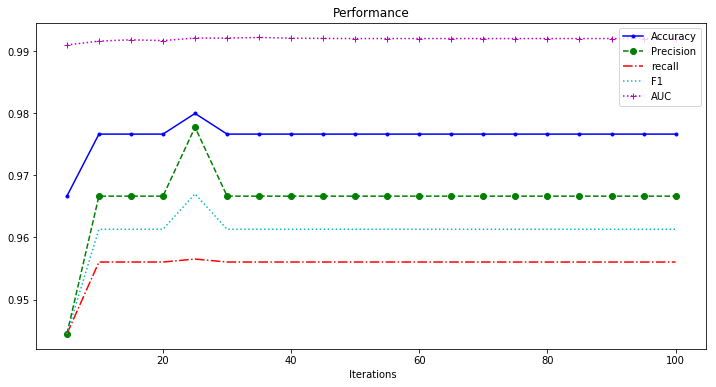

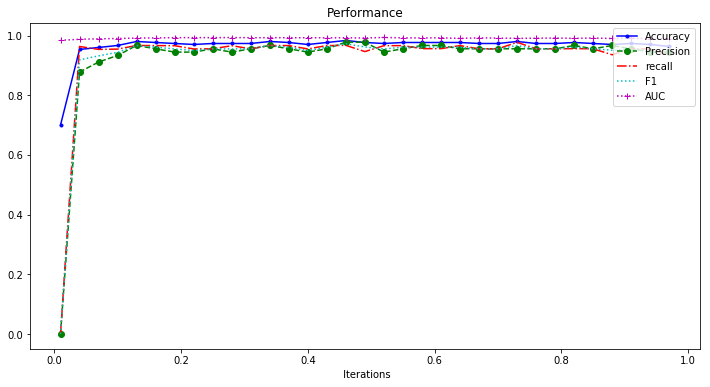

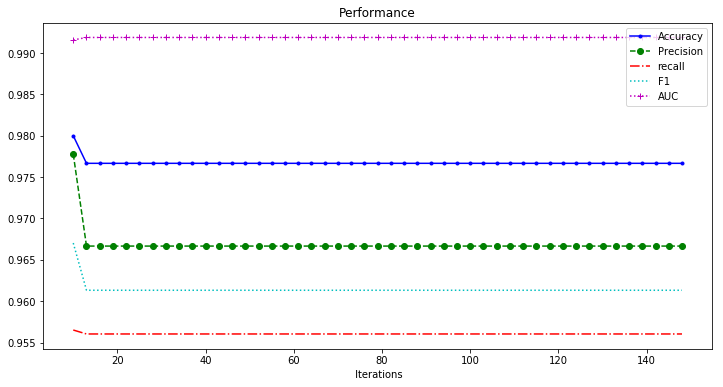

In [9]:

lgbm_n_estimators=list(np.arange(5,105,5))
lgbm_learning_rate=list(np.arange(0.01,1,0.03))
lgbm_num_leaves=list(np.arange(10,150,3))
lgbm_L1=[]
lgbm_L2=[]


for i,j in enumerate(np.arange(5,105,5)):
    lgbm_ne=LGBC(num_leaves=13,learning_rate=0.58,n_estimators=j,boosting_type='goss',reg_alpha=1,reg_lambda=0)
    lgbm_n_estimators[i]=Base(lgbm_ne,train_data=X_train_original,test_data=X_test_original,data=X)

    
    

for i,j in enumerate(np.arange(0.01,1,0.03)):
    lgbm_lr=LGBC(num_leaves=13,learning_rate=j,n_estimators=15,
                boosting_type='goss',reg_alpha=1,reg_lambda=0)
    lgbm_learning_rate[i]=Base(lgbm_lr,train_data=X_train_original,test_data=X_test_original,data=X)
    
    

for i,j in enumerate(np.arange(10,150,3)):
    lgbm_nl=LGBC(num_leaves=j,learning_rate=0.58,n_estimators=15,
                boosting_type='goss',reg_alpha=1,reg_lambda=0)
    lgbm_num_leaves[i]=Base(lgbm_nl,train_data=X_train_original,test_data=X_test_original,data=X)
    
    

    
    
lgbm_l1=LGBC(num_leaves=13,learning_rate=0.58,
             n_estimators=15,boosting_type='goss',reg_alpha=1,reg_lambda=0)
lgbm_L1=Base(lgbm_l1,train_data=X_train_original,test_data=X_test_original,data=X)    
    
lgbm_l2=LGBC(num_leaves=13,learning_rate=0.58,
             n_estimators=15,boosting_type='goss',reg_alpha=0,reg_lambda=1)
lgbm_L2=Base(lgbm_l2,train_data=X_train_original,test_data=X_test_original,data=X)  
    


    
    
np.save('lgbm_n_estimators.npy',lgbm_n_estimators)
np.save('lgbm_learning_rate.npy',lgbm_learning_rate)
np.save('lgbm_depth.npy',lgbm_num_leaves)

np.save('lgbm_result.npy',lgbm_result)
np.save('lgbm_result_pre_data.npy',lgbm_result_pre_data)

np.save('lgbm_L1.npy',lgbm_L1)
np.save('lgbm_L2.npy',lgbm_L2)


plot_result(np.arange(5,105,5),lgbm_n_estimators)
plot_result(np.arange(0.01,1,0.03),lgbm_learning_rate)
plot_result(np.arange(10,150,3),lgbm_num_leaves)




In [4]:
?LGBC

In [17]:
result_best_estimator=np.load('result_best_estimator.npy')

Ada_param=[{'n_estimators':np.arange(5,105,5),'learning_rate':np.arange(0.01,1,0.03)}]
Ada_result_gnb_pre=Individual(Ada(result_best_estimator[-1]),Ada_param,methods='predict_proba')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [16]:
print(Ada_result_gnb[:5])
print(Ada_result_gnb[-1])
np.save('Ada_result_gnb.npy',Ada_result_gnb)

[0.98, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.86564542101709]
246.17670351096604


In [4]:
lgbm_L1=np.load('lgbm_L1.npy')
lgbm_L2=np.load('lgbm_L2.npy')
print(lgbm_L1[:5],lgbm_L1[-1])
print(lgbm_L2[:5],lgbm_L2[-1])

[0.9766666666666667 0.9666666666666667 0.9560439560439561
 0.9613259668508287 0.9918757467144564] 0.019868284813128412
[0.9766666666666667 0.9666666666666667 0.9560439560439561
 0.9613259668508287 0.9908035946184612] 0.02076843669055961


In [ ]:
#######################################Bagging###############################################################################
#######################################Bagging###############################################################################

Bagging_param=[{'n_estimators':np.arange(5,105,5),'max_samples':np.arange(0.1,1,0.1),'max_features':[1.0]}]
Bagging_result=[0,0,0,0,0,0,0,0]

Bagging_result[0]=Individual(Bagging(result_best_estimator[0]),Bagging_param,methods='decision_function')
Bagging_result[1]=Individual(Bagging(result_best_estimator[1]),Bagging_param,methods='decision_function')
Bagging_result[2]=Individual(Bagging(result_best_estimator[2]),Bagging_param,train_data=X_train_original,
                         test_data=X_test_original,data=X)
Bagging_result[3]=Individual(Bagging(result_best_estimator[3]),Bagging_param,methods='predict_proba')
Bagging_result[4]=Individual(Bagging(result_best_estimator[4]),Bagging_param,methods='predict_proba')
Bagging_result[5]=Individual(Bagging(result_best_estimator[5]),Bagging_param,methods='predict_proba')
Bagging_result[6]=Individual(Bagging(gnb),Bagging_param,methods='predict_proba')

Bagging_result_num=np.array([Bagging_result[0][:5],Bagging_result[1][:5],Bagging_result[2][:5],Bagging_result[3][:5],Bagging_result[4][:5],
                         Bagging_result[5][:5],Bagging_result[6][:5]])

Bagging_result_best_param=np.array([Bagging_result[0][9],Bagging_result[1][9],Bagging_result[2][9],Bagging_result[3][9],Bagging_result[4][9],
                         Bagging_result[5][9],Bagging_result[6][9]])

Bagging_result_best_estimator=np.array([Bagging_result[0][10],Bagging_result[1][10],Bagging_result[2][10],Bagging_result[3][10],
                                        Bagging_result[4][10],Bagging_result[5][10],Bagging_result[6][10]])

Bagging_result_runtime=np.array([Bagging_result[0][-1],Bagging_result[1][-1],Bagging_result[2][-1],Bagging_result[3][-1],
                                 Bagging_result[4][-1],Bagging_result[5][-1],Bagging_result[6][-1]])

np.savetxt('Bagging_result_num.txt',Bagging_result_num)
np.save('Bagging_result_best_param.npy',Bagging_result_best_param)
np.save('Bagging_result_best_estimator.npy',Bagging_result_best_estimator)
np.savetxt('Bagging_result_runtime.txt',Bagging_result_runtime)

print('Baggingboost 运行结果','\n',Bagging_result_num)
print('****************************************************')
print('单学习器运行结果','\n',result_number)
print('****************************************************')
print('Bagging各学习器的最优参数','\n',Bagging_result_best_param)
print('*********************************************************')
print('Baggingboost运行时间','\n',Bagging_result_runtime)
print('****************************************************')
################################################################



In [18]:
Bagging_result_num=np.array([Bagging_result[0][:5],Bagging_result[1][:5],Bagging_result[2][:5],Bagging_result[3][:5],Bagging_result[4][:5],
                         Bagging_result[5][:5],Bagging_result[6][:5]])

Bagging_result_best_param=np.array([Bagging_result[0][9],Bagging_result[1][9],Bagging_result[2][9],Bagging_result[3][9],Bagging_result[4][9],
                         Bagging_result[5][9],Bagging_result[6][9]])

Bagging_result_best_estimator=np.array([Bagging_result[0][10],Bagging_result[1][10],Bagging_result[2][10],Bagging_result[3][10],
                                        Bagging_result[4][10],Bagging_result[5][10],Bagging_result[6][10]])

Bagging_result_runtime=np.array([Bagging_result[0][-1],Bagging_result[1][-1],Bagging_result[2][-1],Bagging_result[3][-1],
                                 Bagging_result[4][-1],Bagging_result[5][-1],Bagging_result[6][-1]])

np.savetxt('Bagging_result_num.txt',Bagging_result_num)
np.save('Bagging_result_best_param.npy',Bagging_result_best_param)
np.save('Bagging_result_best_estimator.npy',Bagging_result_best_estimator)
np.savetxt('Bagging_result_runtime.txt',Bagging_result_runtime)

print('Baggingboost 运行结果','\n',Bagging_result_num)
print('****************************************************')
print('单学习器运行结果','\n',result_number)
print('****************************************************')
print('Bagging各学习器的最优参数','\n',Bagging_result_best_param)
print('*********************************************************')
print('Baggingboost运行时间','\n',Bagging_result_runtime)
print('****************************************************')
################################################################



Baggingboost 运行结果 
 [[0.97       0.96666667 0.93548387 0.95081967 0.98570672]
 [0.97       0.96666667 0.93548387 0.95081967 0.99022804]
 [0.97333333 0.96666667 0.94565217 0.95604396 0.98681731]
 [0.96333333 0.92222222 0.95402299 0.93785311 0.99114228]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94518726]
 [0.90666667 0.93333333 0.79245283 0.85714286 0.9478905 ]
 [0.89666667 0.93333333 0.7706422  0.84422111 0.93835957]]
****************************************************
单学习器运行结果 
 [[0.97       0.96666667 0.93548387 0.95081967 0.98576905]
 [0.97333333 0.96666667 0.94565217 0.95604396 0.99034024]
 [0.96333333 0.91111111 0.96470588 0.93714286 0.91304348]
 [0.97       0.94444444 0.95505618 0.94972067 0.98306893]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94399252]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94628019]
 [0.89       0.93333333 0.75675676 0.8358209  0.93526882]]
****************************************************
Bagging各学习器的最优参数 
 [{'max_features': 1.0, 'max_sa

198.41542596917225
562.083453890199
40.41325793670012
623.6758785765282
47.39802510503068
30.50501389509145


NameError: name 'Subspace' is not defined

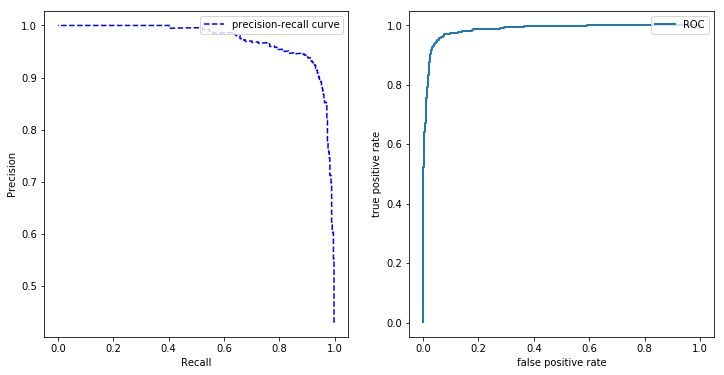

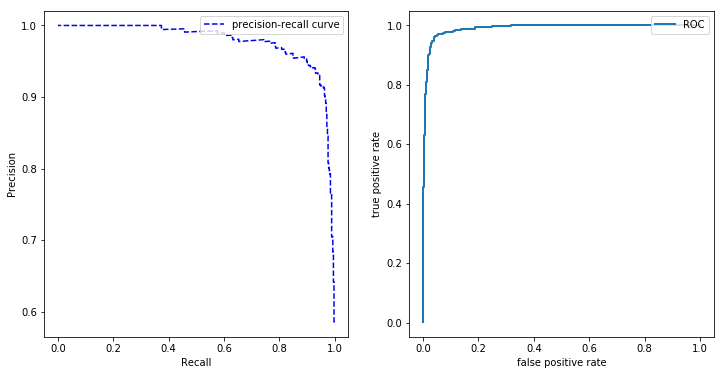

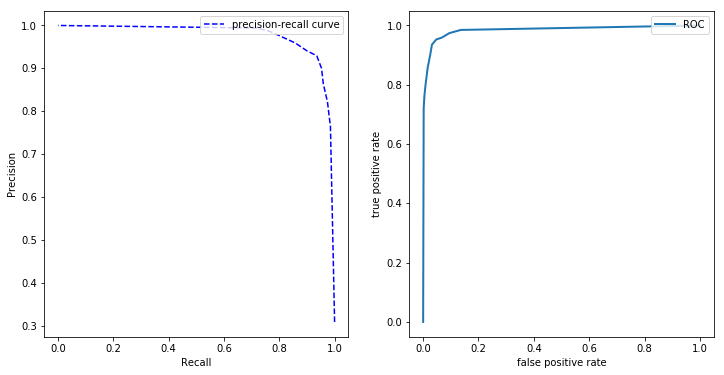

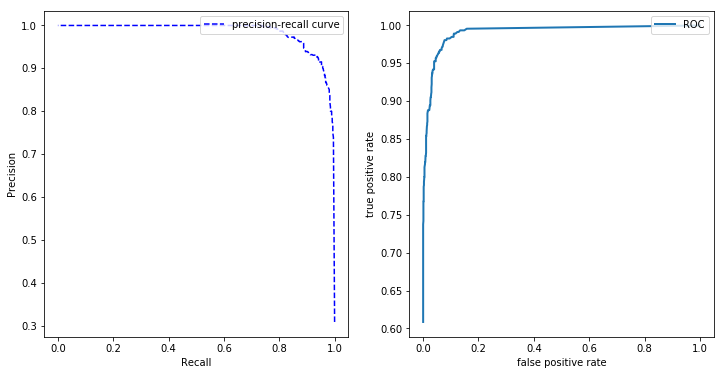

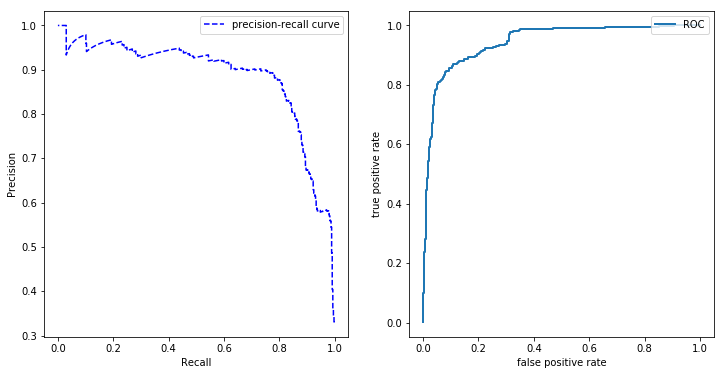

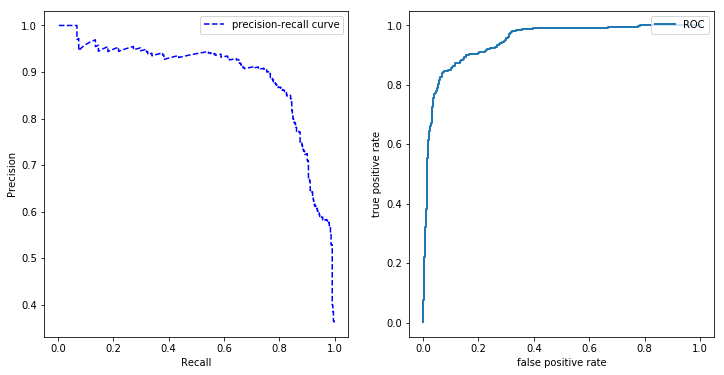

In [11]:
####################################################Random Subspace############################################################################
Subspace_param=[{'n_estimators':np.arange(5,105,5),'max_features':np.arange(0.1,1,0.1),'max_samples':[1.0], 
                 'bootstrap':[False], 'bootstrap_features':[True]}]
Subspace_result=[0,0,0,0,0,0,0,0]

Subspace_result[0]=Individual(Bagging(result_best_estimator[0]),Subspace_param,methods='decision_function')
Subspace_result[1]=Individual(Bagging(result_best_estimator[1]),Subspace_param,methods='decision_function')
Subspace_result[2]=Individual(Bagging(result_best_estimator[2]),Subspace_param,train_data=X_train_original,
                         test_data=X_test_original,data=X)
Subspace_result[3]=Individual(Bagging(result_best_estimator[3]),Subspace_param,methods='predict_proba')
Subspace_result[4]=Individual(Bagging(result_best_estimator[4]),Subspace_param,methods='predict_proba')
Subspace_result[5]=Individual(Bagging(result_best_estimator[5]),Subspace_param,methods='predict_proba')
Subspace_result[6]=Individual(Bagging(gnb),Subspace_param,methods='predict_proba')



In [19]:
#Subspace_result[6]=Individual(Bagging(gnb),Subspace_param,methods='predict_proba')

Subspace_result_num=np.array([Subspace_result[0][:5],Subspace_result[1][:5],Subspace_result[2][:5],Subspace_result[3][:5],Subspace_result[4][:5],
                         Subspace_result[5][:5],Subspace_result[6][:5]])

Subspace_result_best_param=np.array([Subspace_result[0][9],Subspace_result[1][9],Subspace_result[2][9],Subspace_result[3][9],Subspace_result[4][9],
                         Subspace_result[5][9],Subspace_result[6][9]])

Subspace_result_best_estimator=np.array([Subspace_result[0][10],Subspace_result[1][10],Subspace_result[2][10],Subspace_result[3][10],
                                        Subspace_result[4][10],Subspace_result[5][10],Subspace_result[6][10]])

Subspace_result_runtime=np.array([Subspace_result[0][-1],Subspace_result[1][-1],Subspace_result[2][-1],Subspace_result[3][-1],
                                 Subspace_result[4][-1],Subspace_result[5][-1],Subspace_result[6][-1]])

np.savetxt('Subspace_result_num.txt',Subspace_result_num)
np.save('Subspace_result_best_param.npy',Subspace_result_best_param)
np.save('Subspace_result_best_estimator.npy',Subspace_result_best_estimator)
np.savetxt('Subspace_result_runtime.txt',Subspace_result_runtime)

print('Subspace运行结果','\n',Subspace_result_num)
print('****************************************************')
print('单学习器运行结果','\n',result_number)
print('****************************************************')
print('Subspace各学习器的最优参数','\n',Subspace_result_best_param)
print('*********************************************************')
print('Subspaceboost运行时间','\n',Subspace_result_runtime)
print('****************************************************')
################################################################

Subspace运行结果 
 [[0.97       0.96666667 0.93548387 0.95081967 0.98590619]
 [0.97333333 0.96666667 0.94565217 0.95604396 0.98990598]
 [0.97       0.94444444 0.95505618 0.94972067 0.98423043]
 [0.97       0.94444444 0.95505618 0.94972067 0.9910415 ]
 [0.92666667 0.91111111 0.85416667 0.88172043 0.9443686 ]
 [0.92       0.82222222 0.90243902 0.86046512 0.94708015]
 [0.89333333 0.86666667 0.79591837 0.82978723 0.94105969]]
****************************************************
单学习器运行结果 
 [[0.97       0.96666667 0.93548387 0.95081967 0.98576905]
 [0.97333333 0.96666667 0.94565217 0.95604396 0.99034024]
 [0.96333333 0.91111111 0.96470588 0.93714286 0.91304348]
 [0.97       0.94444444 0.95505618 0.94972067 0.98306893]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94399252]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94628019]
 [0.89       0.93333333 0.75675676 0.8358209  0.93526882]]
****************************************************
Subspace各学习器的最优参数 
 [{'bootstrap': False, 'bootstrap_f

1750.2521895079963
1917.0290698964345
275.11769270372497
3253.671280254179
415.3836663698985
262.39432335029596
330.1263241581182
Patchesboost 运行结果 
 [[0.97       0.96666667 0.93548387 0.95081967 0.98572334]
 [0.97333333 0.96666667 0.94565217 0.95604396 0.990307  ]
 [0.98       0.94444444 0.98837209 0.96590909 0.98178069]
 [0.97333333 0.95555556 0.95555556 0.95555556 0.99001714]
 [0.85666667 0.9        0.70434783 0.7902439  0.94688276]
 [0.93       0.92222222 0.8556701  0.88770053 0.94633629]
 [0.88333333 0.76666667 0.8313253  0.79768786 0.93802815]]
****************************************************
单学习器运行结果 
 [[0.97       0.96666667 0.93548387 0.95081967 0.98576905]
 [0.97333333 0.96666667 0.94565217 0.95604396 0.99034024]
 [0.96333333 0.91111111 0.96470588 0.93714286 0.91304348]
 [0.97       0.94444444 0.95505618 0.94972067 0.98306893]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94399252]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94628019]
 [0.89       0.93333333 0.75675

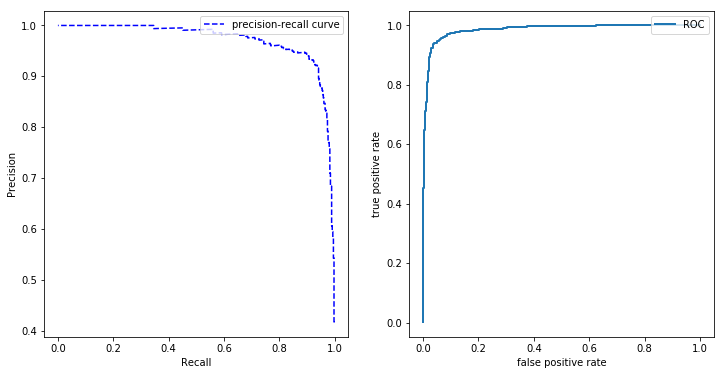

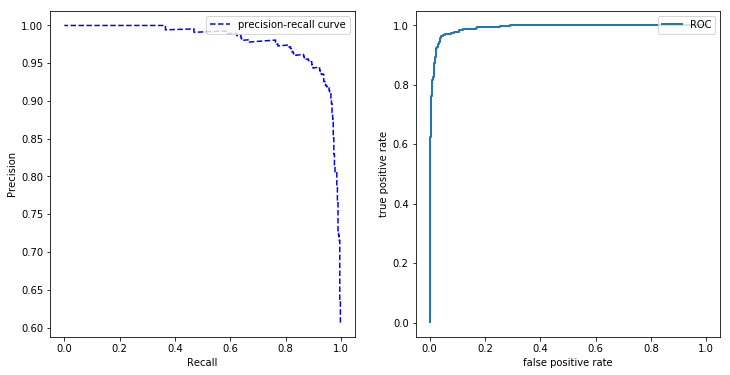

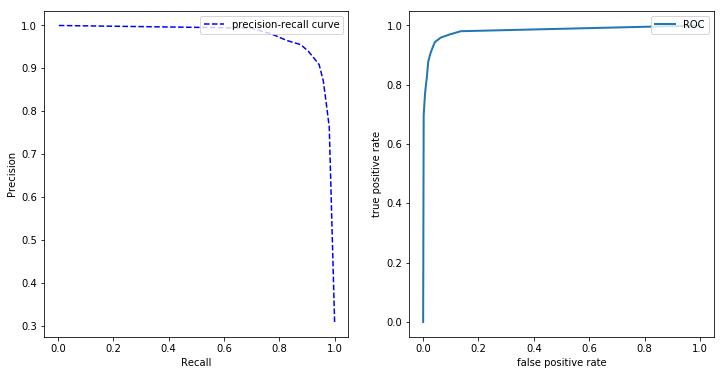

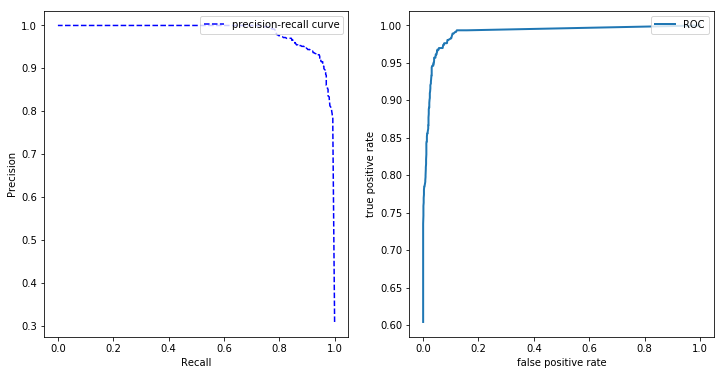

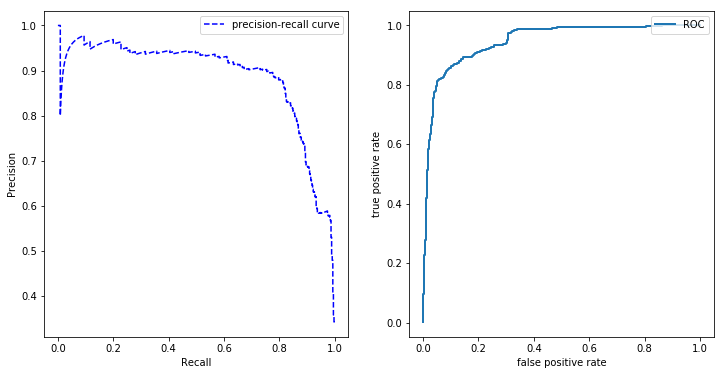

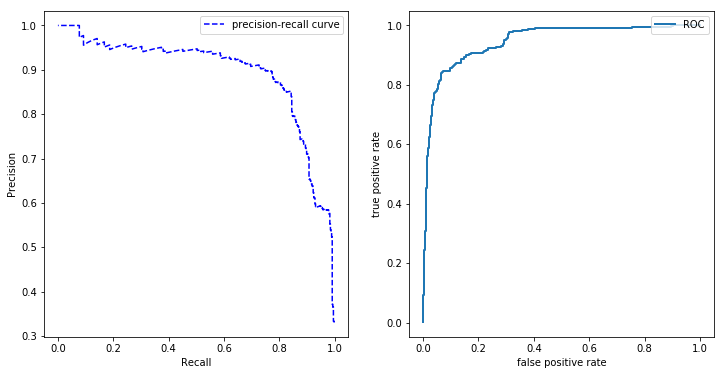

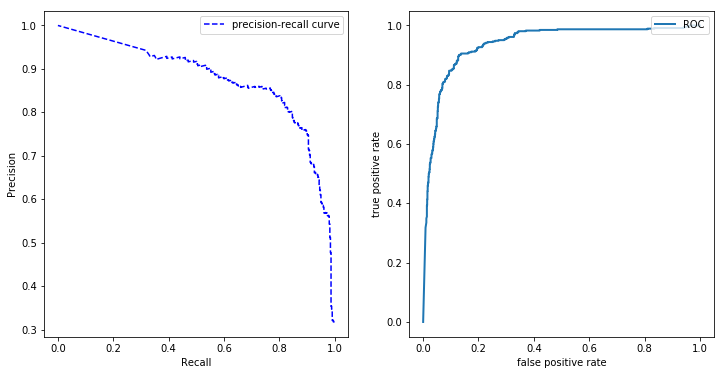

In [16]:
#################################################Random Patches##########################################################################
Patches_param=[{'n_estimators':np.arange(5,105,5),'max_features':np.arange(0.1,1,0.1),'max_samples':np.arange(0.1,1,0.1),
                'bootstrap':[True],'bootstrap_features':[True]}]
Patches_result=[0,0,0,0,0,0,0,0]

Patches_result[0]=Individual(Bagging(result_best_estimator[0]),Patches_param,methods='decision_function')
Patches_result[1]=Individual(Bagging(result_best_estimator[1]),Patches_param,methods='decision_function')
Patches_result[2]=Individual(Bagging(result_best_estimator[2]),Patches_param,train_data=X_train_original,
                         test_data=X_test_original,data=X)
Patches_result[3]=Individual(Bagging(result_best_estimator[3]),Patches_param,methods='predict_proba')
Patches_result[4]=Individual(Bagging(result_best_estimator[4]),Patches_param,methods='predict_proba')
Patches_result[5]=Individual(Bagging(result_best_estimator[5]),Patches_param,methods='predict_proba')
Patches_result[6]=Individual(Bagging(gnb),Patches_param,methods='predict_proba')



####################################################################################################################################


In [20]:
Patches_result_num=np.array([Patches_result[0][:5],Patches_result[1][:5],Patches_result[2][:5],Patches_result[3][:5],Patches_result[4][:5],
                         Patches_result[5][:5],Patches_result[6][:5]])

Patches_result_best_param=np.array([Patches_result[0][9],Patches_result[1][9],Patches_result[2][9],Patches_result[3][9],Patches_result[4][9],
                         Patches_result[5][9],Patches_result[5][9]])

Patches_result_best_estimator=np.array([Patches_result[0][10],Patches_result[1][10],Patches_result[2][10],Patches_result[3][10],
                                        Patches_result[4][10],Patches_result[5][10],Patches_result[6][10]])

Patches_result_runtime=np.array([Patches_result[0][-1],Patches_result[1][-1],Patches_result[2][-1],Patches_result[3][-1],
                                 Patches_result[4][-1],Patches_result[5][-1],Patches_result[6][-1]])

np.savetxt('Patches_result_num.txt',Patches_result_num)
np.save('Patches_result_best_param.npy',Patches_result_best_param)
np.save('Patches_result_num.best_estimator',Patches_result_best_estimator)
np.savetxt('Patches_result_runtime.txt',Patches_result_runtime)

print('Patches运行结果','\n',Patches_result_num)
print('****************************************************')
print('单学习器运行结果','\n',result_number)
print('****************************************************')
print('Patches各学习器的最优参数','\n',Patches_result_best_param)
print('*********************************************************')
print('Patchesboost运行时间','\n',Patches_result_runtime)
print('****************************************************')
################################################################

Patches运行结果 
 [[0.97       0.96666667 0.93548387 0.95081967 0.98572334]
 [0.97333333 0.96666667 0.94565217 0.95604396 0.990307  ]
 [0.98       0.94444444 0.98837209 0.96590909 0.98178069]
 [0.97333333 0.95555556 0.95555556 0.95555556 0.99001714]
 [0.85666667 0.9        0.70434783 0.7902439  0.94688276]
 [0.93       0.92222222 0.8556701  0.88770053 0.94633629]
 [0.88333333 0.76666667 0.8313253  0.79768786 0.93802815]]
****************************************************
单学习器运行结果 
 [[0.97       0.96666667 0.93548387 0.95081967 0.98576905]
 [0.97333333 0.96666667 0.94565217 0.95604396 0.99034024]
 [0.96333333 0.91111111 0.96470588 0.93714286 0.91304348]
 [0.97       0.94444444 0.95505618 0.94972067 0.98306893]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94399252]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94628019]
 [0.89       0.93333333 0.75675676 0.8358209  0.93526882]]
****************************************************
Patches各学习器的最优参数 
 [{'bootstrap': True, 'bootstrap_feat

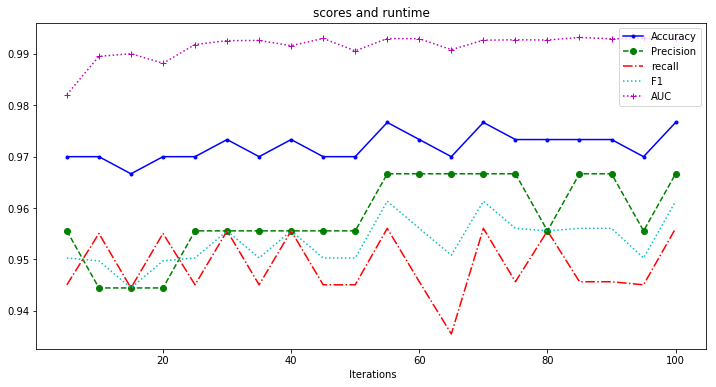

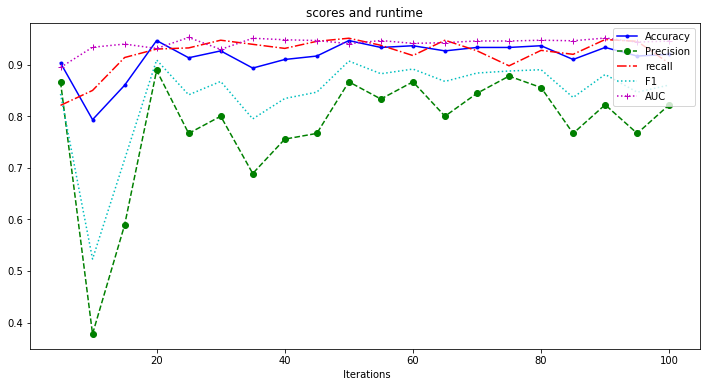

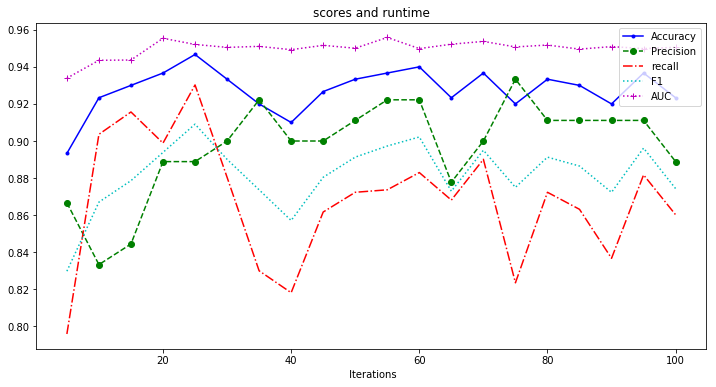

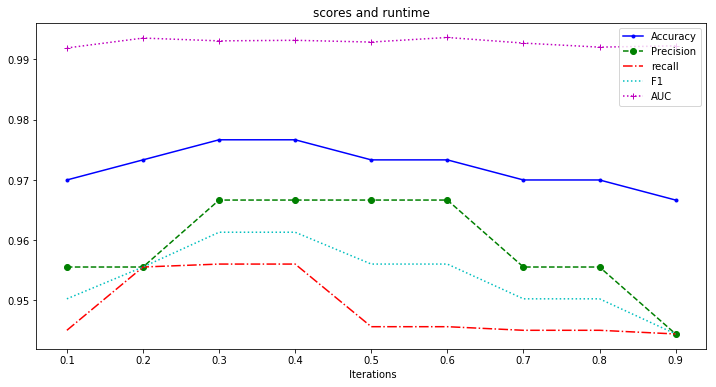

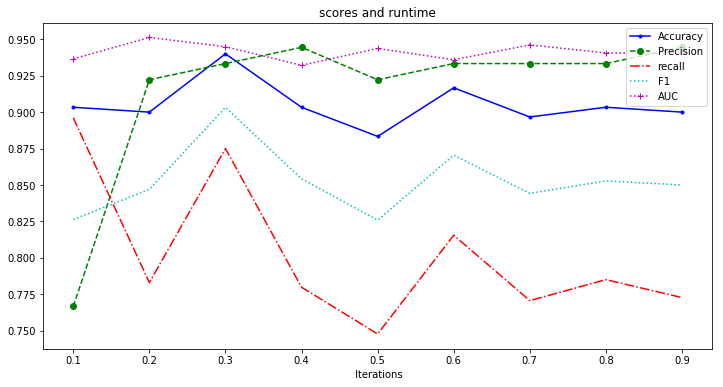

In [25]:
#######################################Bagging optimal##############################################


Bagging_result_ne=list(np.arange(5,105,5))
Subspace_result_ne=list(np.arange(5,105,5))
Patches_result_ne=list(np.arange(5,105,5))

for i,j in enumerate(np.arange(5,105,5)):
    Bagging_ne=Bagging(result_best_estimator[2],n_estimators=j,max_features=1.0,max_samples=0.5,bootstrap=True,bootstrap_features=False)
    Subspace_ne=Bagging(result_best_estimator[4],n_estimators=j,max_features=0.1,max_samples=1.0,bootstrap=False,bootstrap_features=True)
    Patches_ne=Bagging(result_best_estimator[5],n_estimators=j,max_features=0.3,max_samples=0.1,bootstrap=True,bootstrap_features=True)
    
    Bagging_result_ne[i]=Base(Bagging_ne)
    Subspace_result_ne[i]=Base(Subspace_ne)
    Patches_result_ne[i]=Base(Patches_ne)

Bagging_result_sr=list(np.arange(0.1,1,0.1))
Subspace_result_sr=list(np.arange(0.1,1,0.1))
Patches_result_sr=[]


for i,j in enumerate(np.arange(0.1,1,0.1)):
    Bagging_sr=Bagging(result_best_estimator[2],n_estimators=100,max_features=1.0,max_samples=j,bootstrap=True,bootstrap_features=False)
    Subspace_sr=Bagging(result_best_estimator[4],n_estimators=10,max_features=j,max_samples=1.0,bootstrap=False,bootstrap_features=True)
    
    Bagging_result_sr[i]=Base(Bagging_sr)
    Subspace_result_sr[i]=Base(Subspace_sr)
    
for i,j in enumerate(np.arange(0.1,1,0.1)):
    for m,n in enumerate(np.arange(0.1,1,0.1)):
        Patches_sr=Bagging(result_best_estimator[5],n_estimators=45,max_features=j,max_samples=n,bootstrap=True,bootstrap_features=True)
        
        Patches_result_sr.append(Base(Patches_sr))
        
np.save('Bagging_result_ne.npy',Bagging_result_ne)
np.save('Subspace_result_ne.npy',Subspace_result_ne)
np.save('Patches_result_ne.npy',Patches_result_ne)

np.save('Bagging_result_sr.npy',Bagging_result_sr)
np.save('Subspace_result_sr.npy',Subspace_result_sr)
np.save('Patches_result_sr.npy',Patches_result_sr)



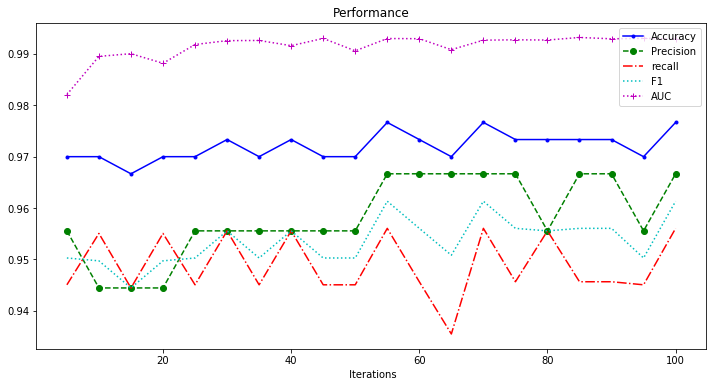

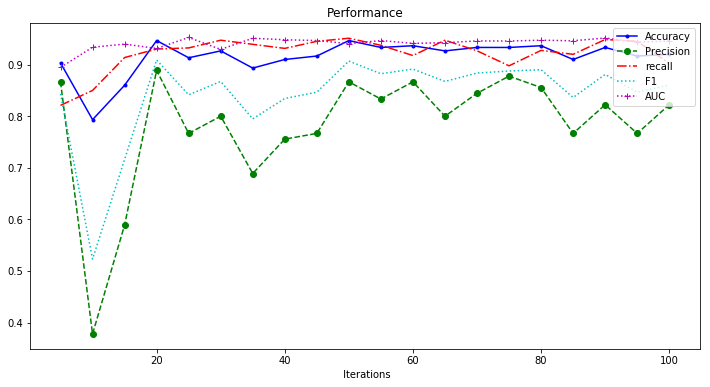

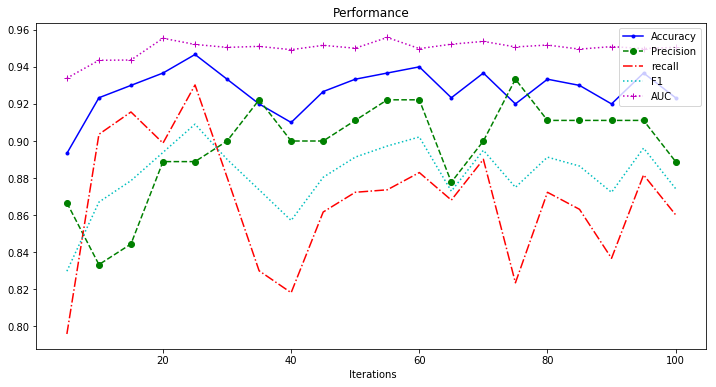

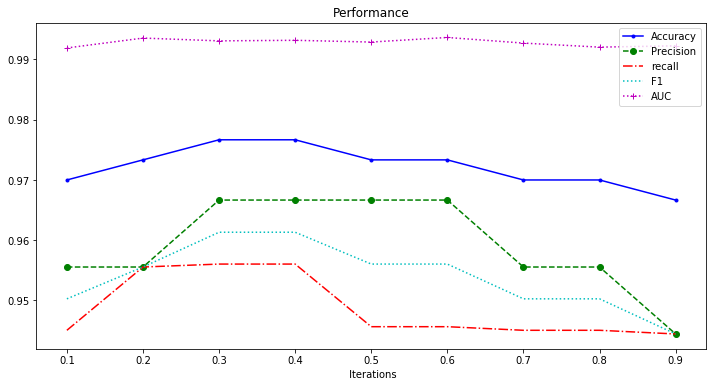

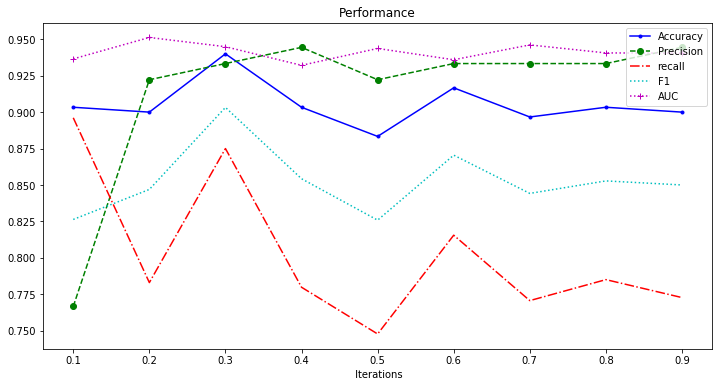

In [41]:
plot_result(np.arange(5,105,5),Bagging_result_ne)
plot_result(np.arange(5,105,5),Subspace_result_ne)
plot_result(np.arange(5,105,5),Patches_result_ne)

plot_result(np.arange(0.1,1,0.1),Bagging_result_sr)  
plot_result(np.arange(0.1,1,0.1),Subspace_result_sr)  
########???3Dplot#########################################


594.0425141439773
596.4899491698452
random forest结果 
 [0.9733333333333334, 0.9444444444444444, 0.9659090909090909, 0.9550561797752809, 0.9886011116305646]
*********************************************************
random forest特征重要度: 
 [0.20743268 0.07758726 0.05653333 0.01949204 0.00843475 0.07430952
 0.01775629 0.01858917 0.03038377 0.09459117 0.01844966 0.04840985
 0.02980331 0.02015553 0.02699084 0.01545973 0.01292463 0.00782374
 0.00861534 0.00130803 0.05264383 0.05460435 0.00125346 0.0886187
 0.00782902]
***************************************************************
random forest最优参数 
 {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 90, 'n_jobs': -1}
*********************************************************
random forest运行时间 
 594.0425141439773


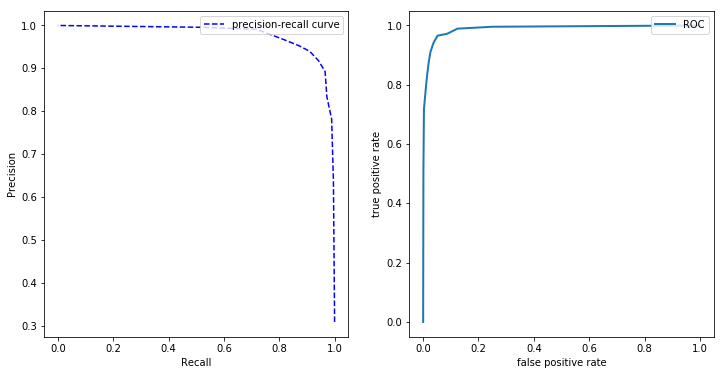

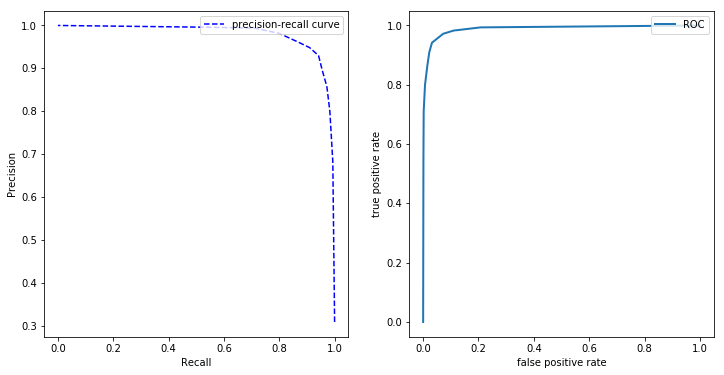

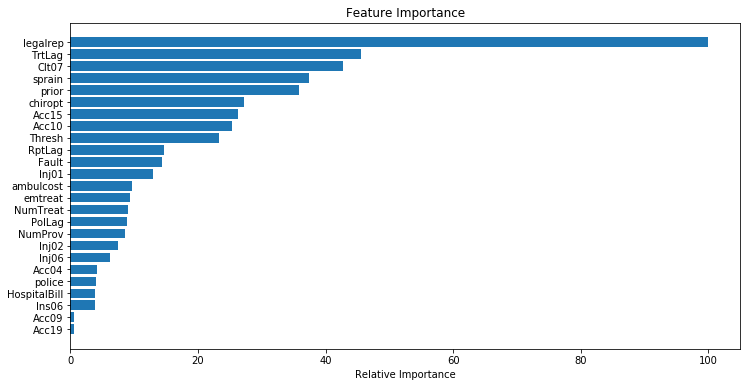

In [37]:
#################################random forest#################################################################

rf=RF()
rf_param=[{'n_estimators':np.arange(5,105,5),'criterion':['gini','entropy'],'max_depth':np.arange(3,16),'n_jobs':[-1]}]
rf_result=Individual(rf,rf_param,train_data=X_train_original,test_data=X_test_original,data=X)

rf_result_pre_data=Individual(rf,rf_param)




print('random forest结果','\n',rf_result[:5])
print('*********************************************************')
print('random forest特征重要度:','\n',rf_result[-2].feature_importances_)
print('***************************************************************')
print('random forest最优参数','\n',rf_result[-3])
print('*********************************************************')
print('random forest运行时间','\n',rf_result[-1])


np.save('rf_result.npy',rf_result)
np.save('rf_result_pre_data.npy',rf_result_pre_data)



plot_feature_importance(rf_result)


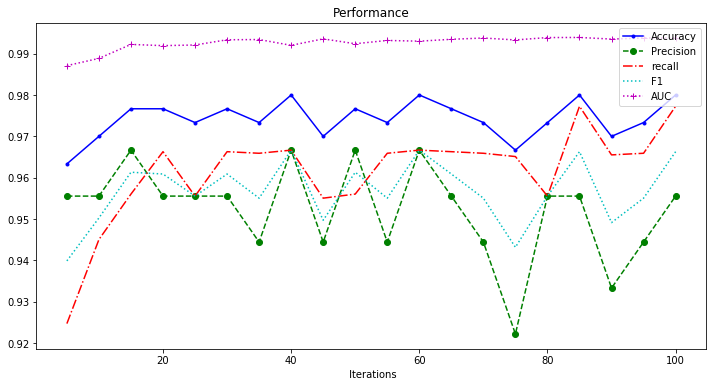

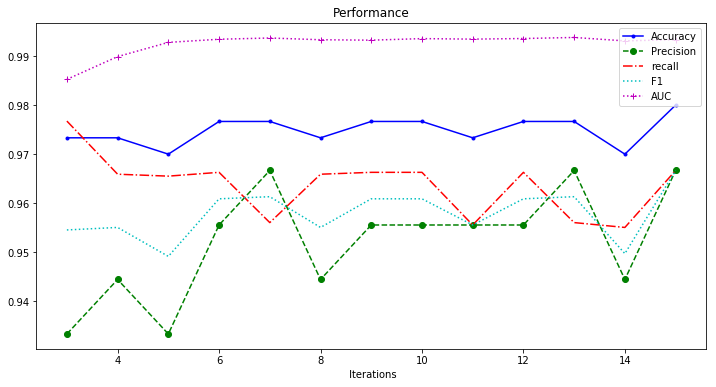

In [48]:
rf_result_ne=list(np.arange(5,105,5))
rf_result_md=list(np.arange(3,16))

for i,j in enumerate(np.arange(5,105,5)):
    rf_ne=RF(n_estimators=j,criterion='gini',max_depth=8,n_jobs=-1)
    rf_result_ne[i]=Base(rf_ne,train_data=X_train_original,test_data=X_test_original,data=X)
for i,j in enumerate(range(3,16)):
    rf_md=RF(n_estimators=90,criterion='gini',max_depth=j,n_jobs=-1)
    rf_result_md[i]=Base(rf_md,train_data=X_train_original,test_data=X_test_original,data=X)

np.save('rf_result_ne.npy',rf_result_ne)
np.save('rf_result_md.npy',rf_result_md)

plot_result(np.arange(5,105,5),rf_result_ne)

plot_result(np.arange(3,16),rf_result_md)   

592.2769264683739
590.580327850199
ExtraTree结果 
 [0.97, 0.9555555555555556, 0.945054945054945, 0.9502762430939227, 0.9875383096981976]
*********************************************************
ExtraTree特征重要度: 
 [0.26397108 0.05699796 0.07907313 0.01079454 0.01860889 0.06541696
 0.01617684 0.01623981 0.0179523  0.04549473 0.01394709 0.08148263
 0.02475444 0.01244081 0.01735316 0.00704466 0.02844105 0.01353265
 0.01664339 0.00187283 0.05123085 0.04953661 0.00306857 0.07743614
 0.01048887]
***************************************************************
ExtraTree最优参数 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 12, 'n_estimators': 25, 'n_jobs': -1}
*********************************************************
ExtraTree运行时间 
 592.2769264683739


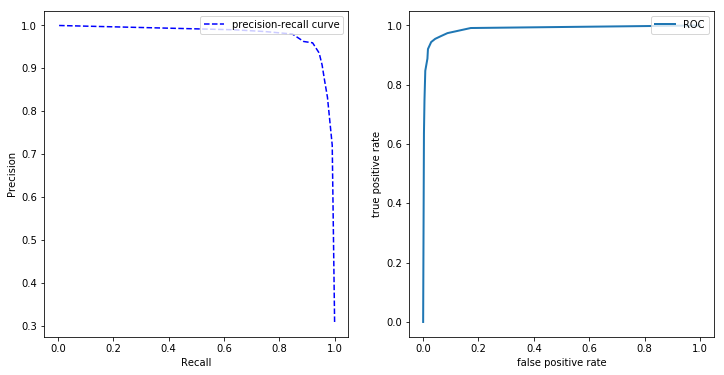

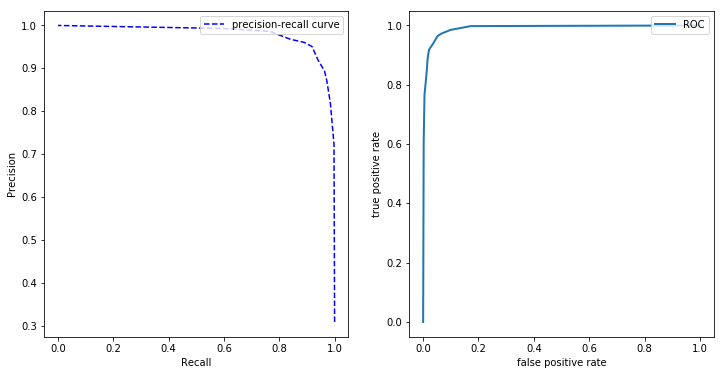

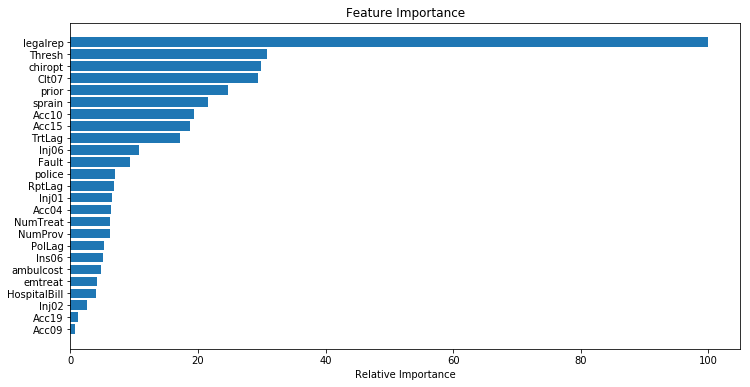

In [43]:
#################################extra tree#################################################################

extree=ExtraTree()
extree_param=[{'n_estimators':np.arange(5,105,5),'criterion':['gini','entropy'],'max_depth':np.arange(3,16),'n_jobs':[-1],'bootstrap':[True]}]
extree_result=Individual(extree,extree_param,train_data=X_train_original,test_data=X_test_original,data=X)
extree_result_pre_data=Individual(extree,extree_param)



print('ExtraTree结果','\n',extree_result[:5])
print('*********************************************************')
print('ExtraTree特征重要度:','\n',extree_result[-2].feature_importances_)
print('***************************************************************')
print('ExtraTree最优参数','\n',extree_result[-3])
print('*********************************************************')
print('ExtraTree运行时间','\n',extree_result[-1])

np.save('extree_result.npy',extree_result)
np.save('extree_result_pre_data.npy',extree_result_pre_data)

plot_feature_importance(extree_result)





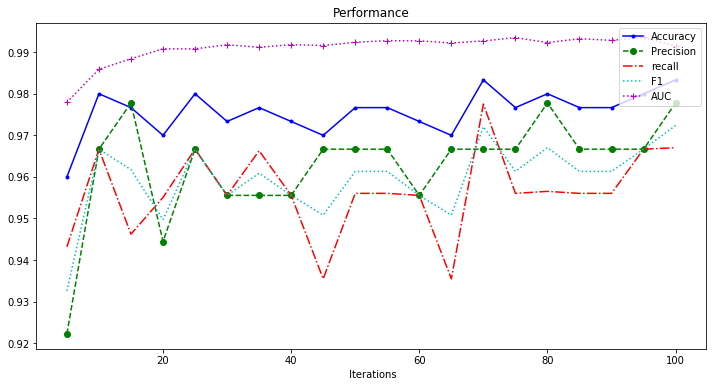

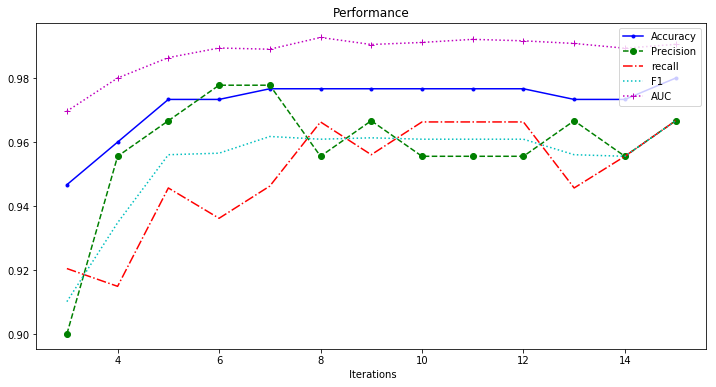

In [46]:
extree_result_ne=list(np.arange(5,105,5))
extree_result_md=list(np.arange(3,16))

for i,j in enumerate(np.arange(5,105,5)):
    extree_ne=ExtraTree(n_estimators=j,criterion='gini',max_depth=12,n_jobs=-1,bootstrap=True)
    extree_result_ne[i]=Base(extree_ne,train_data=X_train_original,test_data=X_test_original,data=X)
for i,j in enumerate(np.arange(3,16)):
    extree_md=ExtraTree(n_estimators=25,criterion='gini',max_depth=j,n_jobs=-1,bootstrap=True)
    extree_result_md[i]=Base(extree_md,train_data=X_train_original,test_data=X_test_original,data=X)


np.save('extree_result_ne.npy',extree_result_ne)
np.save('extree_result_md.npy',extree_result_md)

plot_result(np.arange(5,105,5),extree_result_ne)

plot_result(np.arange(3,16),extree_result_md)   

In [ ]:
################################Stacking###########################################################################
meta=LR()
?Stacking
param_stacking={'use_probas':[True],'average_probas':[True,False],'use_features_in_secondary':[True,False]}
stacking_base=result_best_estimator
stacking_boosting=[Ada_result_best_estimator[-2],GBDT_result[-2],xgb_result[-2],lgbm_result[-2]]
stacking_bagging=[Bagging_result_best_estimator[2],Subspace_result_best_estimator[4],Patches_result_best_estimator[5],
                  rf_result[-2],extree_result[-2]]
stacking_ensemble=[Ada_result_best_estimator[-2],GBDT_result[-2],xgb_result[-2],lgbm_result[-2],
                   Bagging_result_best_estimator[2],Subspace_result_best_estimator[4],Patches_result_best_estimator[5],
                  rf_result[-2],extree_result[-2]]
stacking_blended=[]
for i in stacking_base:
    stacking_blended.append(i)
for i in stacking_ensemble:
    stacking_blended.append(i)

stacking_result_nonproba_pre_data=[0,0,0,0,0]
stacking_result_proba_pre_data=[0,0,0,0,0]

for i,classifier in enumerate([stacking_base,stacking_boosting,stacking_bagging,stacking_ensemble,stacking_belended]):
    stacking_result_nonproba_pre_data[i]=Generator(StackingCV(classfiers=classifier,meta_classifier=meta))
    
for i,classifier in enumerate([stacking_base,stacking_boosting,stacking_bagging,stacking_ensemble,stacking_belended]):
    stacking_result_proba_pre_data[i]=Individual(StackingCV(classfiers=classifier,meta_classifier=meta),param=param_stacking)
    
    
stacking_result_nonproba=[0,0,0,0,0]
stacking_result_proba=[0,0,0,0,0]

for i,classifier in enumerate([stacking_base,stacking_boosting,stacking_bagging,stacking_ensemble,stacking_belended]):
    stacking_result_nonproba[i]=Generator(StackingCV(classfiers=classifier,meta_classifier=meta),
                                                      train_data=X_train_original,test_data=X_test_original,data=X)
    
for i,classifier in [stacking_base,stacking_boosting,stacking_bagging,stacking_ensemble,stacking_belended]:
    stacking_result_proba[i]=Individual(StackingCV(classfiers=classifier,meta_classifier=meta),param=param_stacking,
                                                   train_data=X_train_original,test_data=X_test_original,data=X)
    
np.save('stacking_result_nonproba_pre_data.npy',stacking_result_nonproba_pre_data)
np.save('stacking_result_proba_pre_data.npy',stacking_result_proba_pre_data)
np.save('stacking_result_nonproba.npy',stacking_result_nonproba)
np.save('stacking_result_proba.npy',stacking_result_proba)




In [ ]:
print('stacking_result_nonproba_pre_data结果','\n',stacking_result_nonproba_pre_data[:][:5])
print('*********************************************************')
print('stacking_result_nonproba_pre_data运行时间','\n',stacking_result_nonproba_pre_data[:][-1])
print('*********************************************************')


print('stacking_result_nonproba结果','\n',stacking_result_nonproba[:][:5])
print('*********************************************************')
print('stacking_result_nonproba运行时间','\n',stacking_result_nonproba[:][-1])
print('*********************************************************')

print('stacking_result_proba_pre_data结果','\n',stacking_result_proba_pre_data[:][:5])
print('*********************************************************')
print('stacking_result_proba_pre_data最优参数','\n',stacking_result_proba_pre_data[:][-3])
print('*********************************************************')
print('stacking_result_proba_pre_data运行时间','\n',stacking_result_proba_pre_data[:][-1])

print('*********************************************************')
print('stacking_result_proba结果','\n',stacking_result_proba[:][:5])
print('*********************************************************')
print('stacking_result_proba最优参数','\n',stacking_result_proba[:][-3])
print('*********************************************************')
print('stacking_result_proba运行时间','\n',stacking_result_proba[:][-1])
